In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/china-physiological-signal-challenge-in-2018/Training_WFDB/A0343.hea
/kaggle/input/china-physiological-signal-challenge-in-2018/Training_WFDB/A6752.mat
/kaggle/input/china-physiological-signal-challenge-in-2018/Training_WFDB/A1593.hea
/kaggle/input/china-physiological-signal-challenge-in-2018/Training_WFDB/A4931.hea
/kaggle/input/china-physiological-signal-challenge-in-2018/Training_WFDB/A2678.hea
/kaggle/input/china-physiological-signal-challenge-in-2018/Training_WFDB/A4512.hea
/kaggle/input/china-physiological-signal-challenge-in-2018/Training_WFDB/A5589.mat
/kaggle/input/china-physiological-signal-challenge-in-2018/Training_WFDB/A5881.mat
/kaggle/input/china-physiological-signal-challenge-in-2018/Training_WFDB/A1582.mat
/kaggle/input/china-physiological-signal-challenge-in-2018/Training_WFDB/A5254.hea
/kaggle/input/china-physiological-signal-challenge-in-2018/Training_WFDB/A0842.mat
/kaggle/input/china-physiological-signal-challenge-in-2018/Training_WFDB/A0536.hea
/kag

In [2]:
!pip install ecg-plot
!pip install biosppy
import tensorflow as tf
from keras import layers
from keras.layers import Input, Dense, Dropout, Activation, BatchNormalization, Add
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPool1D, ZeroPadding1D, LSTM, Bidirectional, Flatten, GlobalAveragePooling2D
from keras.models import Sequential, Model
from keras.layers.merge import concatenate
from scipy.io import loadmat
import glob
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

     |████████████████████████████████| 85 kB 330 kB/s 
  Created wheel for biosppy: filename=biosppy-0.7.3-py2.py3-none-any.whl size=95409 sha256=a721a9f1ee0456df8c4c54c2ca11a1fbbb4f1d3b14c418378e1c461f46770f78
  Stored in directory: /root/.cache/pip/wheels/2f/4f/8f/28b2adc462d7e37245507324f4817ce1c64ef2464f099f4f0b
Successfully built biosppy


In [3]:
SNOMED_scored=pd.read_csv("/kaggle/input/physionet-snomed-mappings/SNOMED_mappings_scored.csv", sep=";")
SNOMED_unscored=pd.read_csv("/kaggle/input/physionet-snomed-mappings/SNOMED_mappings_unscored.csv", sep=";")

In [4]:
SNOMED_scored

,Dx,SNOMED CT Code,Abbreviation,CPSC,CPSC-Extra,StPetersburg,PTB,PTB-XL,Georgia,Total,Notes
0,1st degree av block,270492004,IAVB,722,106,0,0,797,769,2394,NaN
1,atrial fibrillation,164889003,AF,1221,153,2,15,1514,570,3475,NaN
2,atrial flutter,164890007,AFL,0,54,0,1,73,186,314,NaN
3,bradycardia,426627000,Brady,0,271,11,0,0,6,288,NaN
4,complete right bundle branch block,713427006,CRBBB,0,113,0,0,542,28,683,We score 713427006 and 59118001 as the same di...
5,incomplete right bundle branch block,713426002,IRBBB,0,86,0,0,1118,407,1611,NaN
6,left anterior fascicular block,445118002,LAnFB,0,0,0,0,1626,180,1806,NaN
7,left axis deviation,39732003,LAD,0,0,0,0,5146,940,6086,NaN
8,left bundle branch block,164909002,LBBB,236,38,0,0,536,231,1041,NaN
9,low qrs voltages,251146004,LQRSV,0,0,0,0,182,374,556,NaN


In [5]:
disease_classes = SNOMED_scored['Dx'].tolist()
disease_classes

['1st degree av block',
 'atrial fibrillation',
 'atrial flutter',
 'bradycardia',
 'complete right bundle branch block',
 'incomplete right bundle branch block',
 'left anterior fascicular block',
 'left axis deviation',
 'left bundle branch block',
 'low qrs voltages',
 'nonspecific intraventricular conduction disorder',
 'pacing rhythm',
 'premature atrial contraction',
 'premature ventricular contractions',
 'prolonged pr interval',
 'prolonged qt interval',
 'qwave abnormal',
 'right axis deviation',
 'right bundle branch block',
 'sinus arrhythmia',
 'sinus bradycardia',
 'sinus rhythm',
 'sinus tachycardia',
 'supraventricular premature beats',
 't wave abnormal',
 't wave inversion',
 'ventricular premature beats']

In [6]:
hea_file = '../input/china-12lead-ecg-challenge-database-unused/Training_2/Training_2/Q0001.hea'

In [7]:
mappings_scored = pd.read_csv("/kaggle/input/physionet-snomed-mappings/SNOMED_mappings_scored.csv", sep=";")#,usecols = ['Dx','SNOMED CT Code','CPSC-Extra'])
mappings_scored

,Dx,SNOMED CT Code,Abbreviation,CPSC,CPSC-Extra,StPetersburg,PTB,PTB-XL,Georgia,Total,Notes
0,1st degree av block,270492004,IAVB,722,106,0,0,797,769,2394,NaN
1,atrial fibrillation,164889003,AF,1221,153,2,15,1514,570,3475,NaN
2,atrial flutter,164890007,AFL,0,54,0,1,73,186,314,NaN
3,bradycardia,426627000,Brady,0,271,11,0,0,6,288,NaN
4,complete right bundle branch block,713427006,CRBBB,0,113,0,0,542,28,683,We score 713427006 and 59118001 as the same di...
5,incomplete right bundle branch block,713426002,IRBBB,0,86,0,0,1118,407,1611,NaN
6,left anterior fascicular block,445118002,LAnFB,0,0,0,0,1626,180,1806,NaN
7,left axis deviation,39732003,LAD,0,0,0,0,5146,940,6086,NaN
8,left bundle branch block,164909002,LBBB,236,38,0,0,536,231,1041,NaN
9,low qrs voltages,251146004,LQRSV,0,0,0,0,182,374,556,NaN


In [8]:
mappings_unscored = pd.read_csv("../input/physionet-snomed-mappings/SNOMED_mappings_unscored.csv", sep=";")#,usecols = ['Dx','SNOMED CT Code','CPSC-Extra'])
mappings_unscored

,Dx,SNOMED CT Code,Abbreviation,CPSC,CPSC-Extra,StPetersburg,PTB,PTB-XL,Georgia,Total
0,2nd degree av block,195042002,IIAVB,0,21,0,0,14,23,58
1,abnormal QRS,164951009,abQRS,0,0,0,0,3389,0,3389
2,accelerated junctional rhythm,426664006,AJR,0,0,0,0,0,19,19
3,acute myocardial infarction,57054005,AMI,0,0,6,0,0,0,6
4,acute myocardial ischemia,413444003,AMIs,0,1,0,0,0,1,2
...,...,...,...,...,...,...,...,...,...,...
79,ventricular pre excitation,195060002,VPEx,0,6,0,0,0,2,8
80,ventricular tachycardia,164895002,VTach,0,1,1,10,0,0,12
81,ventricular trigeminy,251180001,VTrig,0,4,4,0,20,1,29
82,wandering atrial pacemaker,195101003,WAP,0,0,0,0,0,7,7


In [9]:
mappings = pd.read_csv("../input/china-12lead-ecg-challenge-database-unused/Dx_map.csv")#, sep=";")#,usecols = ['Dx','SNOMED CT Code','CPSC-Extra'])
mappings

,Dx,SNOMED CT Code,Abbreviation
0,1st degree av block,270492004,IAVB
1,2nd degree av block,195042002,IIAVB
2,abnormal QRS,164951009,abQRS
3,accelerated junctional rhythm,426664006,AJR
4,acute myocardial infarction,57054005,AMI
...,...,...,...
106,ventricular pre excitation,195060002,VPEx
107,ventricular tachycardia,164895002,VTach
108,ventricular trigeminy,251180001,VTrig
109,wandering atrial pacemaker,195101003,WAP


In [10]:
mappings_scored['SNOMED CT Code'] = mappings_scored['SNOMED CT Code'].astype(object)

In [11]:
d = dict()
for i in range(27):
    d[mappings_scored.iloc[i]["SNOMED CT Code"]] = mappings_scored.iloc[i]["Dx"]
d

{270492004: '1st degree av block',
 164889003: 'atrial fibrillation',
 164890007: 'atrial flutter',
 426627000: 'bradycardia',
 713427006: 'complete right bundle branch block',
 713426002: 'incomplete right bundle branch block',
 445118002: 'left anterior fascicular block',
 39732003: 'left axis deviation',
 164909002: 'left bundle branch block',
 251146004: 'low qrs voltages',
 698252002: 'nonspecific intraventricular conduction disorder',
 10370003: 'pacing rhythm',
 284470004: 'premature atrial contraction',
 427172004: 'premature ventricular contractions',
 164947007: 'prolonged pr interval',
 111975006: 'prolonged qt interval',
 164917005: 'qwave abnormal',
 47665007: 'right axis deviation',
 59118001: 'right bundle branch block',
 427393009: 'sinus arrhythmia',
 426177001: 'sinus bradycardia',
 426783006: 'sinus rhythm',
 427084000: 'sinus tachycardia',
 63593006: 'supraventricular premature beats',
 164934002: 't wave abnormal',
 59931005: 't wave inversion',
 17338001: 'ventric

### Converting the keys and values to string type for allowing comparison with the dataset codes

In [12]:
keys_values = d.items()
d = {str(key): str(value) for key, value in keys_values}
d

{'270492004': '1st degree av block',
 '164889003': 'atrial fibrillation',
 '164890007': 'atrial flutter',
 '426627000': 'bradycardia',
 '713427006': 'complete right bundle branch block',
 '713426002': 'incomplete right bundle branch block',
 '445118002': 'left anterior fascicular block',
 '39732003': 'left axis deviation',
 '164909002': 'left bundle branch block',
 '251146004': 'low qrs voltages',
 '698252002': 'nonspecific intraventricular conduction disorder',
 '10370003': 'pacing rhythm',
 '284470004': 'premature atrial contraction',
 '427172004': 'premature ventricular contractions',
 '164947007': 'prolonged pr interval',
 '111975006': 'prolonged qt interval',
 '164917005': 'qwave abnormal',
 '47665007': 'right axis deviation',
 '59118001': 'right bundle branch block',
 '427393009': 'sinus arrhythmia',
 '426177001': 'sinus bradycardia',
 '426783006': 'sinus rhythm',
 '427084000': 'sinus tachycardia',
 '63593006': 'supraventricular premature beats',
 '164934002': 't wave abnormal',


In [13]:
mat_files = sorted(glob.glob('../input/china-12lead-ecg-challenge-database-unused/Training_2/Training_2/*.mat'))
hea_files = sorted(glob.glob('../input/china-12lead-ecg-challenge-database-unused/Training_2/Training_2/*.hea'))

### Denoising the ECG signal
1. The first filter is a butterworth highpass filter to remove low freqeuncy noise
2. The second is a butterworth lowpass filter to remove high frequency noise
3. The final is a notch filter to remove power line noise caused by other electrical appliances when the signal is recorded

In [14]:
from scipy import signal
from scipy.signal import butter, iirnotch, lfilter
import scipy.signal as signal
import pywt
import warnings
warnings.filterwarnings("ignore")

#Constants
fs = 1000
cutoff_high = 0.1#0.5
cutoff_low = 50#2
powerline = 60
order = 3

def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5*fs
    normal_cutoff = cutoff/nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False, output='ba')
    return b, a

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5*fs
    normal_cutoff = cutoff/nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False, output='ba')
    return b, a

def notch_filter(cutoff, q):
    nyq = 0.5*fs
    freq = cutoff/nyq
    b, a = iirnotch(freq, q)
    return b, a

def highpass(data, fs, order=5):
    b,a = butter_highpass(cutoff_high, fs, order=order)
    x = lfilter(b,a,data)
    return x

def lowpass(data, fs, order =5):
    b,a = butter_lowpass(cutoff_low, fs, order=order)
    y = lfilter(b,a,data)
    return y

def notch(data, powerline, q):
    b,a = notch_filter(powerline,q)
    z = lfilter(b,a,data)
    return z

def final_filter(data, fs, order=5):
    b, a = butter_highpass(cutoff_high, fs, order=order)
    x = lfilter(b, a, data)
    d, c = butter_lowpass(cutoff_low, fs, order = order)
    y = lfilter(d, c, x)
    f, e = notch_filter(powerline, 30)
    z = lfilter(f, e, y)     
    return z

## Passing relevant metadata and the signal into a CSV file

In [15]:
def info_extract(hea):
    #print(hea)
    infile = (open(hea).readlines())
    #print(infile)
    age = str.rstrip(infile[13][6:])
    #print(age)
    gender = infile[14][6]
    #print(gender)
    diag = str.rstrip(infile[15][5:])
    #print(diag)
    return age,gender,diag

In [16]:
def insert_info(age,gender,dx,filename,ecg,df):
    new_row = {'filename':filename, 'age':age, 'gender':gender, 
               'diagnosis':dx.split(','),
               'ecg_signal':final_filter(ecg['val'],1000,5),
               'Lead I':final_filter(ecg['val'][0],1000,5),
               'Lead II':final_filter(ecg['val'][1] ,1000,5),
               'Lead III':final_filter(ecg['val'][2] ,1000,5),
               'aVR':final_filter(ecg['val'][3] ,1000,5),
               'aVL':final_filter(ecg['val'][4] ,1000,5),
               'aVF':final_filter(ecg['val'][5] ,1000,5),
               'V1':final_filter(ecg['val'][6] , 1000,5),
               'V2':final_filter(ecg['val'][7] ,1000,5),
               'V3':final_filter(ecg['val'][8] ,1000,5),
               'V4':final_filter(ecg['val'][9] ,1000,5),
               'V5':final_filter(ecg['val'][10] ,1000,5),
               'V6':final_filter(ecg['val'][11] ,1000,5),
              }
    df = df.append(new_row, ignore_index=True)
    return df

In [17]:
df = pd.DataFrame(columns = ['filename','age','gender','diagnosis','ecg_signal',
                 'Lead I',
                  'Lead II',
               'Lead III',
               'aVR',
               'aVL',
               'aVF',
               'V1',
               'V2',
               'V3',
               'V4',
               'V5',
               'V6',]
                 )
for hea,mat in zip(hea_files,mat_files):
    age,gender,diag = info_extract(hea)
    ecg = loadmat(mat)
    df = insert_info(age,gender,diag,mat,ecg,df)

In [18]:
df

,filename,age,gender,diagnosis,ecg_signal,Lead I,Lead II,Lead III,aVR,aVL,aVF,V1,V2,V3,V4,V5,V6
0,../input/china-12lead-ecg-challenge-database-u...,53,M,"[164867002, 427084000]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -5.93620328721...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -5.936203287212...","[0.0005936203287212333, 0.006037652244061175, ...","[0.0005936203287212333, 0.006097014276933299, ...","[-0.00029681016436061664, -0.00307818815490271...","[-0.00029681016436061664, -0.00307818815490271...","[0.0006529823615933566, 0.006629545061892868, ...","[0.003086825709350413, 0.03202502921756262, 0....","[0.0026119294463734263, 0.027052438543420584, ...","[0.0010091545588260965, 0.010240264001755145, ...","[0.004452152465409249, 0.04605409825779641, 0....","[0.0009497925259539732, 0.009589009151051332, ...","[0.00053425829584911, 0.005327035360485236, 0...."
1,../input/china-12lead-ecg-challenge-database-u...,70,F,[164861001],"[[0.0011278786245703433, 0.011542773703162784,...","[0.0011278786245703433, 0.011542773703162784, ...","[0.027603345285537352, 0.27422100573291114, 1....","[0.026475466660967006, 0.26267823202974827, 1....","[-0.014306249922181722, -0.14228999690020525, ...","[-0.012644113001762268, -0.12524210173794084, ...","[0.02700972495681611, 0.26818335348884986, 1.3...","[0.0026712914792455496, 0.02693198696678679, 0...","[0.0007717064273376033, 0.00811014086191687, 0...","[0.0013653267560588367, 0.013850982941617431, ...","[0.0035023599394552766, 0.03539657251504687, 0...","[-0.019767556946417065, -0.1963879639434882, -...","[-0.009023028996562746, -0.08854301952148638, ..."
2,../input/china-12lead-ecg-challenge-database-u...,55,M,"[164867002, 428750005]","[[-0.0027900155449897966, -0.02781896243808956...","[-0.0027900155449897966, -0.027818962438089567...","[0.00035617219723273994, 0.003551356906990157,...","[0.0031461877422225364, 0.03137031934507972, 0...","[0.0012466026903145896, 0.012429749174465547, ...","[-0.002968101643606166, -0.029594640891584638,...","[0.0017808609861636997, 0.01775678453495079, 0...","[-0.0008310684602097266, -0.008405223515387946...","[-0.0018995850519079463, -0.01888120813774205,...","[-0.0006529823615933566, -0.006570183029020745...","[-0.00035617219723273994, -0.00355135690699015...","[0.0006529823615933566, 0.006451458963276498, ...","[0.00029681016436061664, 0.0029594640891584642..."
3,../input/china-12lead-ecg-challenge-database-u...,57,M,"[164861001, 428750005]","[[-0.0004748962629769866, -0.00485386660839779...","[-0.0004748962629769866, -0.00485386660839779,...","[-0.0009497925259539732, -0.009589009151051332...","[-0.0004748962629769866, -0.004735142542653543...","[0.0007123443944654799, 0.0071620758468524375,...","[5.936203287212332e-05, 0.0005325307849595696,...","[-0.0007123443944654799, -0.007221437879724561...","[-0.001484050821803083, -0.0155096648402578, -...","[-0.00195894708478007, -0.020422893481527715, ...","[-0.0007717064273376033, -0.007991416796172624...","[-0.0013059647231867132, -0.01349653825527423,...","[-0.00106851659169822, -0.011307053082563828, ...","[-0.00106851659169822, -0.011010242918203211, ..."
4,../input/china-12lead-ecg-challenge-database-u...,51,F,[428750005],"[[0.0005936203287212333, 0.005978290211189051,...","[0.0005936203287212333, 0.005978290211189051, ...","[0.0012466026903145896, 0.013142093568931028, ...","[0.0007123443944654799, 0.007696334142701548, ...","[-0.0008904304930818499, -0.009293926497580257...","[-0.00011872406574424665, -0.00142123376715187...","[0.0009497925259539732, 0.010123267446900444, ...","[0.0055206690571074695, 0.057657961504720856, ...","[0.0017808609861636997, 0.018884663159521132, ...","[0.004333428399665003, 0.04546393295085426, 0....","[0.002968101643606166, 0.03125677781200409, 0....","[0.005223858892746853, 0.054639135382690274, 0...","[0.0026119294463734263, 0.027289886674909076, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3448,../input/china-12lead-ecg-challenge-database-u...,61,M,"[543290

In [19]:
df['diagnosis']

0       [164867002, 427084000]
1                  [164861001]
2       [164867002, 428750005]
3       [164861001, 428750005]
4                  [428750005]
                 ...          
3448     [54329005, 428750005]
3449               [164867002]
3450               [164865005]
3451               [164867002]
3452    [164861001, 428750005]
Name: diagnosis, Length: 3453, dtype: object

# Denoising and Normalizing a sample ECG signal

In [20]:
exg = '../input/china-12lead-ecg-challenge-database-unused/Training_2/Training_2/Q0001.mat'
exg = loadmat(exg)
exg = exg['val']

### Normalizing the signal (before denoising)

In [21]:
# import sklearn.preprocessing as skp

# print("Data = ", exg)
# normalized = skp.normalize(exg)
# print("Normalized Data = ", filter_signal)

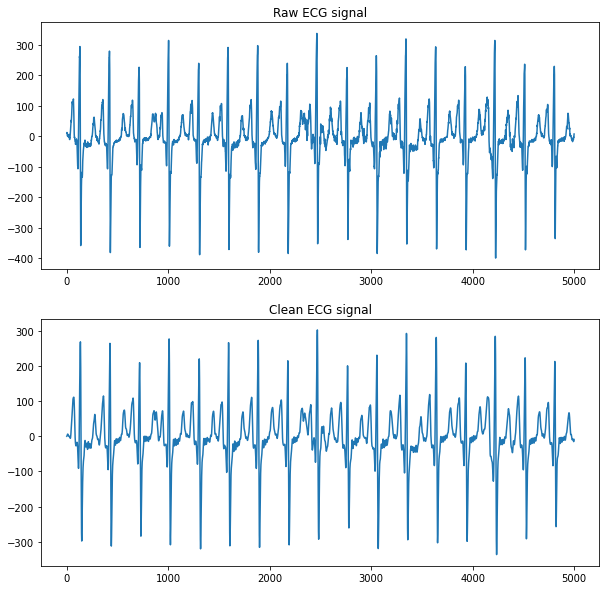

In [22]:
plt.figure(figsize= (10,10))
ax1 = plt.subplot(211)
plt.plot(exg[1])
ax1.set_title("Raw ECG signal")

filter_signal = final_filter(exg, fs, order)
ax2 = plt.subplot(212)
plt.plot(filter_signal[1])
ax2.set_title("Clean ECG signal")
plt.show()

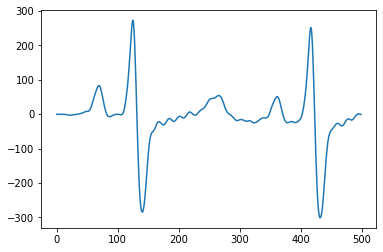

In [23]:
plt.plot(filter_signal[0][0:500])
#plt.plot(exg[0][0:500])

In [24]:
exg.shape

(12, 5000)

### Normalizing the denoised signal

In [25]:
# import sklearn.preprocessing as skp

# print("Data = ", filter_signal)
# normalized = skp.normalize(filter_signal)
# print("Normalized Data = ", normalized)

## Plotting the normalizing and denoised signal

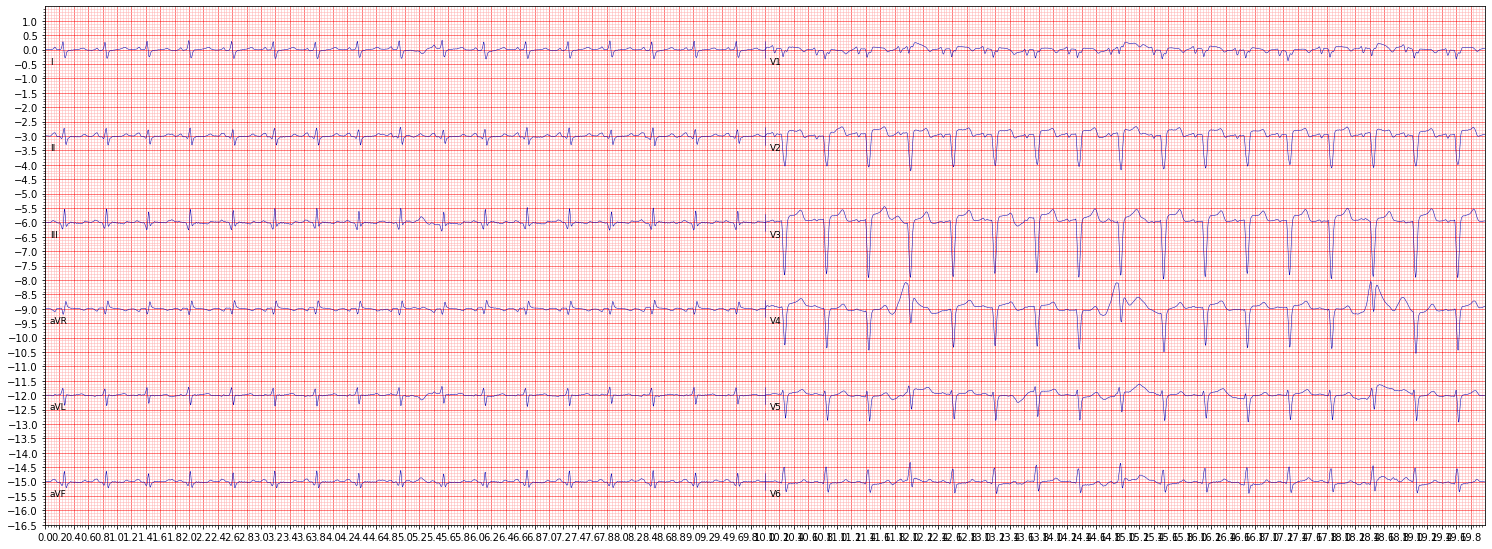

In [26]:
import ecg_plot
def plot_ecg(path):
    ecg_data = pc.load_challenge_data(path)
    ecg_plot.plot(ecg_data[0]/1000, sample_rate=500, title='')
    ecg_plot.show()
def plot_ecg_signal(sig):
    ecg_plot.plot(sig/1000, sample_rate=500, title='')
    ecg_plot.show()
plot_ecg_signal(filter_signal)

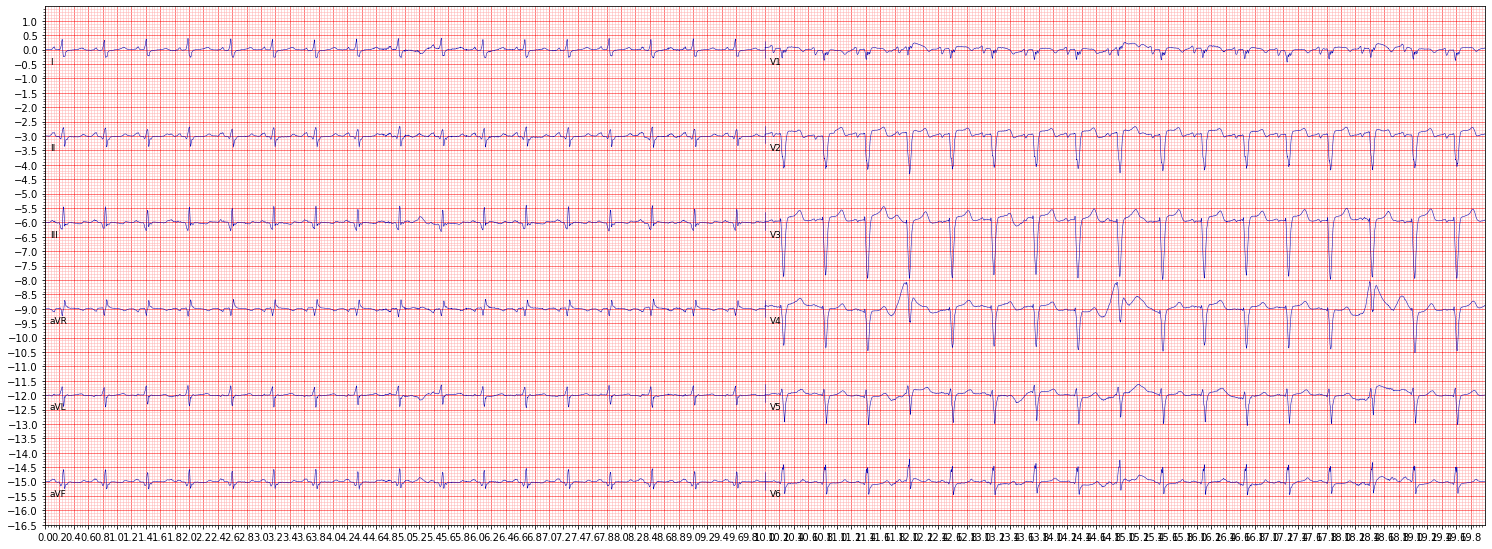

In [27]:
plot_ecg_signal(exg)

# Features to extract from the signal

#### Peak Detection
In the paper 'Deep Neural Network Models for Detection of Arrhythmia based on Electrocardiogram Reports', the V1 lead is used for peak detection

#### Hamilton peak detector function to obtain the QRS wave from the ecg signal

In [28]:
def hamilton_detector(unfiltered_ecg,fs):
        """
        P.S. Hamilton, 
        Open Source ECG Analysis Software Documentation, E.P.Limited, 2002.
        """
        
        f1 = 8/fs
        f2 = 16/fs

        b, a = signal.butter(1, [f1*2, f2*2], btype='bandpass')

        filtered_ecg = signal.lfilter(b, a, unfiltered_ecg)

        diff = abs(np.diff(filtered_ecg))

        b = np.ones(int(0.08*fs))
        b = b/int(0.08*fs)
        a = [1]

        ma = signal.lfilter(b, a, diff)

        ma[0:len(b)*2] = 0

        n_pks = []
        n_pks_ave = 0.0
        s_pks = []
        s_pks_ave = 0.0
        QRS = [0]
        RR = []
        RR_ave = 0.0

        th = 0.0

        i=0
        idx = []
        peaks = []  

        for i in range(len(ma)):

            if i>0 and i<len(ma)-1:
                if (ma[i-1] < ma[i]) and (ma[i+1]<ma[i]):
                    peak = i
                    peaks.append(i)

                    if ma[peak] > th and (peak-QRS[-1])>0.3*fs:        
                        QRS.append(peak)
                        idx.append(i)
                        s_pks.append(ma[peak])
                        if len(n_pks)>8:
                            s_pks.pop(0)
                        s_pks_ave = np.mean(s_pks)

                        if RR_ave != 0.0:
                            if QRS[-1]-QRS[-2] > 1.5*RR_ave:
                                missed_peaks = peaks[idx[-2]+1:idx[-1]]
                                for missed_peak in missed_peaks:
                                    if missed_peak-peaks[idx[-2]]>int(0.360*fs) and ma[missed_peak]>0.5*th:
                                        QRS.append(missed_peak)
                                        QRS.sort()
                                        break

                        if len(QRS)>2:
                            RR.append(QRS[-1]-QRS[-2])
                            if len(RR)>8:
                                RR.pop(0)
                            RR_ave = int(np.mean(RR))

                    else:
                        n_pks.append(ma[peak])
                        if len(n_pks)>8:
                            n_pks.pop(0)
                        n_pks_ave = np.mean(n_pks)

                    th = n_pks_ave + 0.45*(s_pks_ave-n_pks_ave)

                    i+=1

        QRS.pop(0)

        return QRS,RR

In [29]:
#qrs0,rr0 = hamilton_detector(exg[0],500)
qrs0,rr0 = hamilton_detector(filter_signal[0],500)
qrs0 = np.array(qrs0)
qrs0

array([ 159,  433,  725, 1016, 1313, 1620, 1894, 2186, 2495, 2774, 3063,
       3354, 3648, 3940, 4230, 4542, 4817])

In [30]:
np.average(rr0)

290.25

### Peak detection using cross correlation and qrs filter (suggested in paper and code from [Kaggle](https://www.kaggle.com/stetelepta/exploring-heart-rate-variability-using-python))

In [31]:
def detect_peaks(ecg_signal, threshold=0.3, qrs_filter=None):
    '''
    Peak detection algorithm using cross corrrelation and threshold 
    '''
    if qrs_filter is None:
        # create default qrs filter, which is just a part of the sine function
        t = np.linspace(1.5 * np.pi, 3.5 * np.pi, 15)
        qrs_filter = np.sin(t)
    
    # normalize data
    #ecg_signal = list(ecg_signal)
    ecg_signal = (ecg_signal - ecg_signal.mean()) / ecg_signal.std()
    #ecg_signal = skp.normalize(ecg_signa

    # calculate cross correlation
    similarity = np.correlate(ecg_signal, qrs_filter, mode="same")
    similarity = similarity / np.max(similarity)

    peaks = []
    for i in range(len(similarity)):
        if similarity[i] > threshold:
            peaks.append(i)
    # return peaks (values in ms) using threshold
    return peaks, similarity#np.where(ecg_signal[similarity > threshold]), similarity

In [32]:
#indexes, similarity = detect_peaks(exg[1])
indexes, similarity = detect_peaks(filter_signal[0])
similarity

array([ 1.58478755e-05,  7.86096037e-05,  7.29987387e-05, ...,
       -2.03893378e-02, -1.12300665e-02,  3.69109003e-03])

In [33]:
print(indexes)

[122, 123, 124, 125, 126, 127, 128, 129, 130, 149, 150, 151, 152, 153, 154, 155, 414, 415, 416, 417, 418, 419, 420, 421, 422, 441, 442, 443, 444, 445, 446, 447, 706, 707, 708, 709, 710, 711, 712, 713, 734, 735, 736, 737, 738, 996, 997, 998, 999, 1000, 1001, 1002, 1003, 1004, 1025, 1026, 1027, 1028, 1029, 1294, 1295, 1296, 1297, 1298, 1299, 1300, 1301, 1320, 1321, 1322, 1323, 1324, 1325, 1326, 1583, 1584, 1585, 1586, 1587, 1588, 1589, 1590, 1609, 1610, 1611, 1612, 1613, 1614, 1615, 1875, 1876, 1877, 1878, 1879, 1880, 1881, 1882, 1902, 1903, 1904, 1905, 1906, 1907, 1908, 2167, 2168, 2169, 2170, 2171, 2172, 2173, 2174, 2194, 2195, 2196, 2197, 2198, 2199, 2457, 2458, 2459, 2460, 2461, 2462, 2463, 2464, 2465, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2756, 2757, 2758, 2759, 2760, 2761, 2762, 2763, 2783, 2784, 2785, 2786, 2787, 3044, 3045, 3046, 3047, 3048, 3049, 3050, 3051, 3052, 3071, 3072, 3073, 3074, 3075, 3076, 3077, 3336, 3337, 3338, 3339, 3340, 3341, 3342, 3343, 3362, 3363, 3364, 3365

#### Plotting the peak detection result

In [34]:
def get_plot_ranges(start=10, end=20, n=5):
    '''
    Make an iterator that divides into n or n+1 ranges. 
    - if end-start is divisible by steps, return n ranges
    - if end-start is not divisible by steps, return n+1 ranges, where the last range is smaller and ends at n
    
    # Example:
    >> list(get_plot_ranges())
    >> [(0.0, 3.0), (3.0, 6.0), (6.0, 9.0)]

    '''
    distance = end - start
    for i in np.arange(start, end, np.floor(distance/n)):
        yield (int(i), int(np.minimum(end, np.floor(distance/n) + i)))

In [35]:
sampfrom = 0
sampto = 5000
nr_plots = 1
index_ecg = np.arange(sampto)

for start, stop in get_plot_ranges(sampfrom, sampto, nr_plots):
    cond_slice = (index_ecg >= start) & (index_ecg < stop) 
    #ecg_slice = (exg[0][cond_slice])
    ecg_slice = (filter_signal[0][cond_slice])

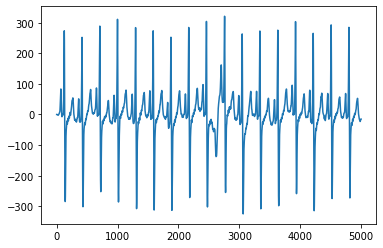

In [36]:
plt.plot((ecg_slice))

Text(0, 0.5, 'Similarity (normalized)')

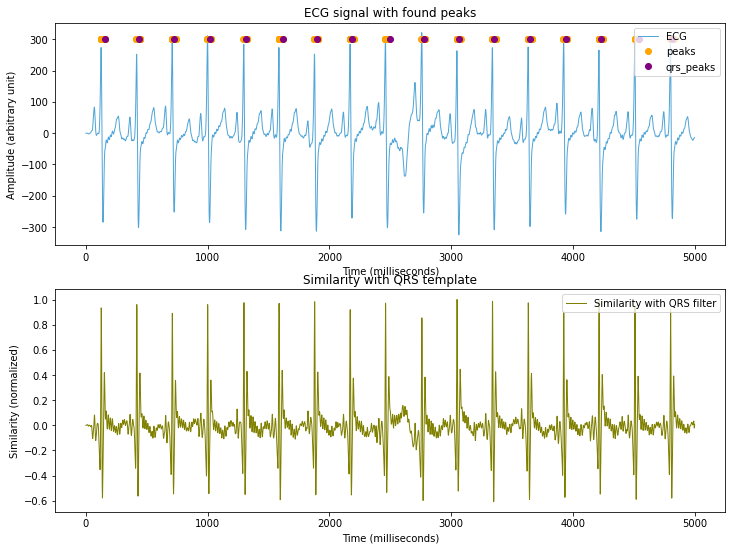

In [37]:
peaks, similarity = detect_peaks(ecg_slice)
plt.figure(figsize=(12, 9))

peaks = np.array(peaks)

plt.subplot(211)
plt.title("ECG signal with found peaks")
plt.plot(index_ecg, ecg_slice, label="ECG", color="#51A6D8", linewidth=1)
plt.plot(peaks, np.repeat(300, peaks.shape[0]), label="peaks", color="orange", marker="o", linestyle="None")
#plt.plot(rpeaks, np.repeat(600, rpeaks.shape[0]), label="rpeaks", color="red", marker="+", linestyle="None")
plt.plot(qrs0, np.repeat(300, qrs0.shape[0]), label="qrs_peaks", color="purple", marker="o", linestyle="None")
#plt.plot(np.cumsum(rr), rr, label="RR-interval", color="#A651D8")
plt.legend(loc="upper right")
plt.xlabel("Time (milliseconds)")
plt.ylabel("Amplitude (arbitrary unit)")
    
plt.subplot(212)
plt.title('Similarity with QRS template')
plt.plot(index_ecg, similarity, label="Similarity with QRS filter", color="olive", linewidth=1)
plt.legend(loc="upper right")
plt.xlabel("Time (milliseconds)")
plt.ylabel("Similarity (normalized)")

In [38]:
peaks

array([ 122,  123,  124,  125,  126,  127,  128,  129,  130,  149,  150,
        151,  152,  153,  154,  155,  414,  415,  416,  417,  418,  419,
        420,  421,  422,  441,  442,  443,  444,  445,  446,  447,  706,
        707,  708,  709,  710,  711,  712,  713,  734,  735,  736,  737,
        738,  996,  997,  998,  999, 1000, 1001, 1002, 1003, 1004, 1025,
       1026, 1027, 1028, 1029, 1294, 1295, 1296, 1297, 1298, 1299, 1300,
       1301, 1320, 1321, 1322, 1323, 1324, 1325, 1326, 1583, 1584, 1585,
       1586, 1587, 1588, 1589, 1590, 1609, 1610, 1611, 1612, 1613, 1614,
       1615, 1875, 1876, 1877, 1878, 1879, 1880, 1881, 1882, 1902, 1903,
       1904, 1905, 1906, 1907, 1908, 2167, 2168, 2169, 2170, 2171, 2172,
       2173, 2174, 2194, 2195, 2196, 2197, 2198, 2199, 2457, 2458, 2459,
       2460, 2461, 2462, 2463, 2464, 2465, 2485, 2486, 2487, 2488, 2489,
       2490, 2491, 2756, 2757, 2758, 2759, 2760, 2761, 2762, 2763, 2783,
       2784, 2785, 2786, 2787, 3044, 3045, 3046, 30

#### Grouping peaks incase some peaks are too close because of the threshold not filtering correctly

In [39]:
from scipy.ndimage import label
def group_peaks(p, threshold=50):
    '''
    The peak detection algorithm finds multiple peaks for each QRS complex. 
    Here we group collections of peaks that are very near (within threshold) and we take the median index 
    '''
    # initialize output
    output = np.empty(0)

    # label groups of sample that belong to the same peak
    peak_groups, num_groups = label(np.diff(p) < threshold)

    # iterate through groups and take the mean as peak index
    for i in np.unique(peak_groups)[1:]:
        peak_group = p[np.where(peak_groups == i)]
        output = np.append(output, np.median(peak_group))
    return output

In [40]:
grouped_peaks = group_peaks(peaks)
grouped_peaks

array([ 129. ,  421. ,  711.5, 1002. , 1300.5, 1589.5, 1881.5, 2173. ,
       2464. , 2761.5, 3051. , 3342.5, 3636. , 3926.5, 4217.5, 4512. ,
       4803.5])

### Example of grouped peaks

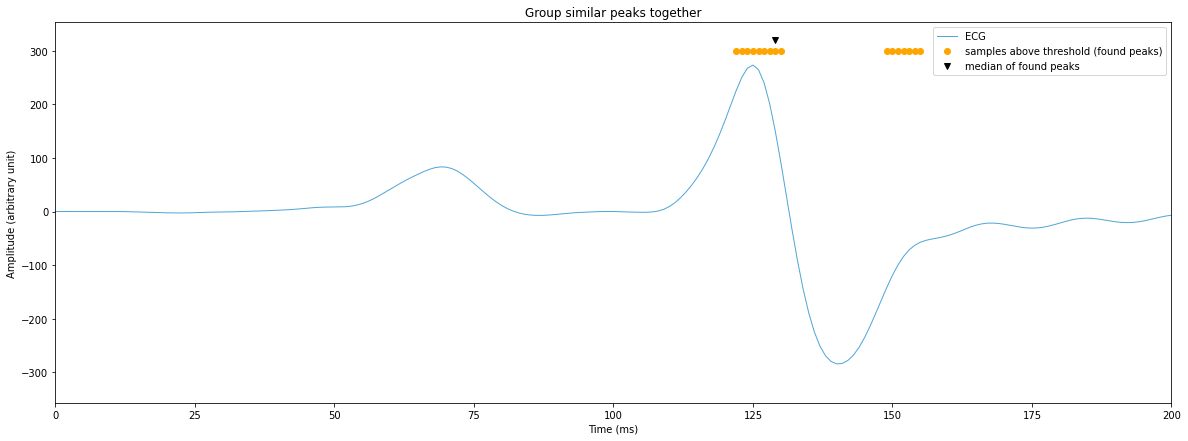

In [41]:
plt.figure(figsize=(20, 7))
plt.title("Group similar peaks together")
plt.plot(index_ecg, ecg_slice, label="ECG", color="#51A6D8", linewidth=1)
plt.plot(peaks, np.repeat(300, peaks.shape[0]),label="samples above threshold (found peaks)", color="orange", marker="o", linestyle="None")
plt.plot(grouped_peaks, np.repeat(320, grouped_peaks.shape[0]), label="median of found peaks", color="k", marker="v", linestyle="None")
plt.legend(loc="upper right")
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude (arbitrary unit)")
plt.gca().set_xlim(0, 200)
plt.show()

In [42]:
rr = np.diff(grouped_peaks)
np.median(rr)

291.5

In [43]:
rr

array([292. , 290.5, 290.5, 298.5, 289. , 292. , 291.5, 291. , 297.5,
       289.5, 291.5, 293.5, 290.5, 291. , 294.5, 291.5])

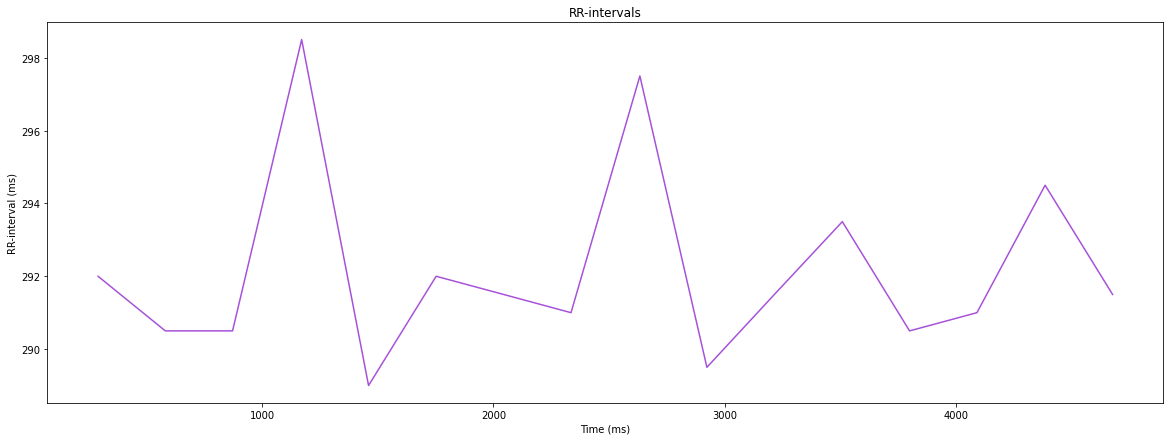

In [44]:
plt.figure(figsize=(20, 7))
plt.title("RR-intervals")
plt.xlabel("Time (ms)")
plt.ylabel("RR-interval (ms)")

plt.plot(np.cumsum(rr), rr, label="RR-interval", color="#A651D8")
plt.show()

Text(0, 0.5, 'Amplitude (arbitrary unit)')

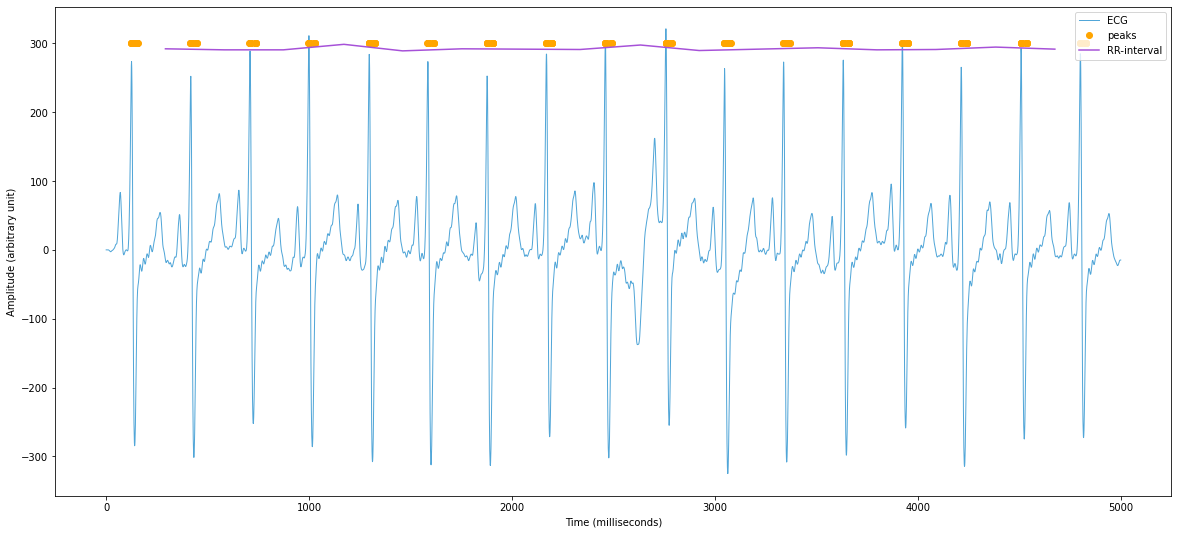

In [45]:
plt.figure(figsize=(20, 9))
plt.plot(index_ecg, ecg_slice, label="ECG", color="#51A6D8", linewidth=1)
plt.plot(peaks, np.repeat(300, peaks.shape[0]), label="peaks", color="orange", marker="o", linestyle="None")
#plt.plot(rpeaks, np.repeat(600, rpeaks.shape[0]), label="rpeaks", color="red", marker="+", linestyle="None")
#plt.plot(qrs0, np.repeat(300, qrs0.shape[0]), label="qrs_peaks", color="purple", marker="o", linestyle="None")
plt.plot(np.cumsum(rr), rr, label="RR-interval", color="#A651D8")
plt.legend(loc="upper right")
plt.xlabel("Time (milliseconds)")
plt.ylabel("Amplitude (arbitrary unit)")

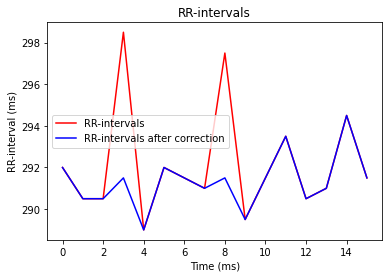

In [46]:
from scipy.stats import zscore
rr_corrected = rr.copy()
rr_corrected[np.abs(zscore(rr)) > 2] = np.median(rr)

plt.title("RR-intervals")
plt.xlabel("Time (ms)")
plt.ylabel("RR-interval (ms)")

plt.plot(rr, color="red", label="RR-intervals")
plt.plot(rr_corrected, color="blue",  label="RR-intervals after correction")
plt.legend()
plt.show()

Text(0, 0.5, 'Amplitude (arbitrary unit)')

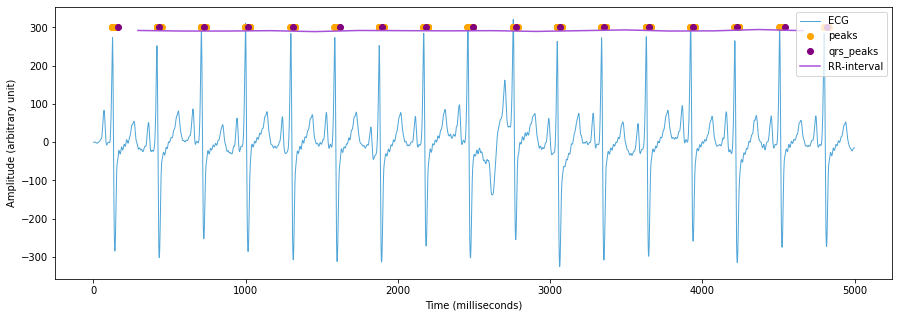

In [47]:
plt.figure(figsize=(15, 5))
plt.plot(index_ecg, ecg_slice, label="ECG", color="#51A6D8", linewidth=1)
plt.plot(peaks, np.repeat(300, peaks.shape[0]), label="peaks", color="orange", marker="o", linestyle="None")
#plt.plot(rpeaks, np.repeat(600, rpeaks.shape[0]), label="rpeaks", color="red", marker="+", linestyle="None")
plt.plot(qrs0, np.repeat(300, qrs0.shape[0]), label="qrs_peaks", color="purple", marker="o", linestyle="None")
plt.plot(np.cumsum(rr_corrected), rr_corrected, label="RR-interval", color="#A651D8")
plt.legend(loc="upper right")
plt.xlabel("Time (milliseconds)")
plt.ylabel("Amplitude (arbitrary unit)")

## Signal Segmentation

In [48]:
grouped_peaks[1] - grouped_peaks[0]

292.0

In [49]:
segment_peaks = grouped_peaks
win = (grouped_peaks[1] - grouped_peaks[0])/2
segment_peaks = (segment_peaks + win).astype(int)
segment_peaks

array([ 275,  567,  857, 1148, 1446, 1735, 2027, 2319, 2610, 2907, 3197,
       3488, 3782, 4072, 4363, 4658, 4949])

In [50]:
len(segment_peaks)

17

In [51]:
ecg_slice[segment_peaks[0]:segment_peaks[1]]

array([ 2.44771058e+01,  1.93667509e+01,  1.47698568e+01,  1.08520061e+01,
        7.67071209e+00,  5.18230008e+00,  3.27928044e+00,  1.82197990e+00,
        6.36314534e-01, -4.84063676e-01, -1.72104142e+00, -3.15891636e+00,
       -4.78296179e+00, -6.55759052e+00, -8.48333987e+00, -1.05553890e+01,
       -1.26895363e+01, -1.47163552e+01, -1.64314826e+01, -1.76627906e+01,
       -1.83291422e+01, -1.84450460e+01, -1.80976405e+01, -1.74373942e+01,
       -1.66568514e+01, -1.59467228e+01, -1.54459238e+01, -1.52258591e+01,
       -1.53177281e+01, -1.57179898e+01, -1.63699506e+01, -1.71788996e+01,
       -1.80539548e+01, -1.89160075e+01, -1.96726529e+01, -2.02168794e+01,
       -2.04378987e+01, -2.02642636e+01, -1.97612019e+01, -1.91484080e+01,
       -1.86876596e+01, -1.85731949e+01, -1.88945449e+01, -1.96393343e+01,
       -2.07168273e+01, -2.19690372e+01, -2.31653291e+01, -2.40788283e+01,
       -2.46051679e+01, -2.47557016e+01, -2.45724209e+01, -2.41025651e+01,
       -2.33933716e+01, -

### Overlapping all the heartbeast segments

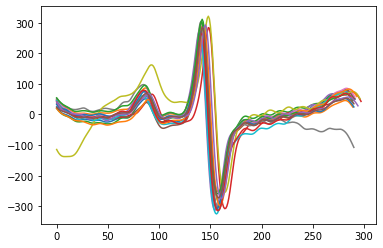

In [52]:
segment_list = []
for i in range(len(segment_peaks)-1):
    segment_list.append(ecg_slice[segment_peaks[i]:segment_peaks[i+1]])
    plt.plot(ecg_slice[segment_peaks[i]:segment_peaks[i+1]])

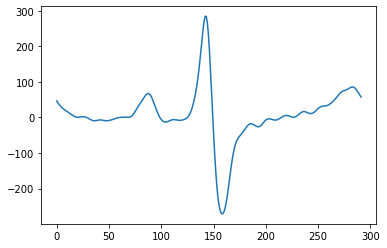

In [53]:
plt.plot(segment_list[6])

### Taking 50 equally distributed samples from one of the segments

In [54]:
segment_list[6].shape

(292,)

In [55]:
sample_indexes = np.arange(0,segment_list[6].shape[0],(segment_list[6].shape[0]/50)).round().astype(int)
sample_indexes

array([  0,   6,  12,  18,  23,  29,  35,  41,  47,  53,  58,  64,  70,
        76,  82,  88,  93,  99, 105, 111, 117, 123, 128, 134, 140, 146,
       152, 158, 164, 169, 175, 181, 187, 193, 199, 204, 210, 216, 222,
       228, 234, 239, 245, 251, 257, 263, 269, 274, 280, 286])

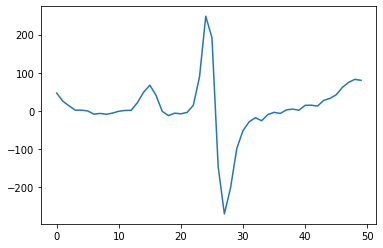

In [56]:
plt.plot(segment_list[6][sample_indexes])

In [57]:
sample_indexes += segment_peaks[6]
sample_indexes

array([2027, 2033, 2039, 2045, 2050, 2056, 2062, 2068, 2074, 2080, 2085,
       2091, 2097, 2103, 2109, 2115, 2120, 2126, 2132, 2138, 2144, 2150,
       2155, 2161, 2167, 2173, 2179, 2185, 2191, 2196, 2202, 2208, 2214,
       2220, 2226, 2231, 2237, 2243, 2249, 2255, 2261, 2266, 2272, 2278,
       2284, 2290, 2296, 2301, 2307, 2313])

#### sample_indexes consists of 50 samples (points on the signal from a single heartbeat)

## Obtaining the Temporal Features

In [58]:
avg_rr_interval = np.average(rr_corrected)
avg_rr_interval

291.34375

In [59]:
pre_rr_interval = segment_list[7].shape[0] 
post_rr_interval = segment_list[5].shape[0]
local_rr = segment_list[6].shape[0]

In [60]:
rr_corrected

array([292. , 290.5, 290.5, 291.5, 289. , 292. , 291.5, 291. , 291.5,
       289.5, 291.5, 293.5, 290.5, 291. , 294.5, 291.5])

## Peak Detection using BioSPPy library

In [61]:
from biosppy.signals.ecg import christov_segmenter,extract_heartbeats

rpeaks = christov_segmenter(signal=ecg_slice, sampling_rate=500.0)
rpeaks = np.array(tuple(rpeaks))
rpeaks

array([[ 125,  417,  709,  999, 1296, 1585, 1877, 2169, 2460, 2758, 3047,
        3338, 3632, 3923, 4213, 4508, 4800]])

# Converting the target labels to a sparse matrix 

In [62]:
df

,filename,age,gender,diagnosis,ecg_signal,Lead I,Lead II,Lead III,aVR,aVL,aVF,V1,V2,V3,V4,V5,V6
0,../input/china-12lead-ecg-challenge-database-u...,53,M,"[164867002, 427084000]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -5.93620328721...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -5.936203287212...","[0.0005936203287212333, 0.006037652244061175, ...","[0.0005936203287212333, 0.006097014276933299, ...","[-0.00029681016436061664, -0.00307818815490271...","[-0.00029681016436061664, -0.00307818815490271...","[0.0006529823615933566, 0.006629545061892868, ...","[0.003086825709350413, 0.03202502921756262, 0....","[0.0026119294463734263, 0.027052438543420584, ...","[0.0010091545588260965, 0.010240264001755145, ...","[0.004452152465409249, 0.04605409825779641, 0....","[0.0009497925259539732, 0.009589009151051332, ...","[0.00053425829584911, 0.005327035360485236, 0...."
1,../input/china-12lead-ecg-challenge-database-u...,70,F,[164861001],"[[0.0011278786245703433, 0.011542773703162784,...","[0.0011278786245703433, 0.011542773703162784, ...","[0.027603345285537352, 0.27422100573291114, 1....","[0.026475466660967006, 0.26267823202974827, 1....","[-0.014306249922181722, -0.14228999690020525, ...","[-0.012644113001762268, -0.12524210173794084, ...","[0.02700972495681611, 0.26818335348884986, 1.3...","[0.0026712914792455496, 0.02693198696678679, 0...","[0.0007717064273376033, 0.00811014086191687, 0...","[0.0013653267560588367, 0.013850982941617431, ...","[0.0035023599394552766, 0.03539657251504687, 0...","[-0.019767556946417065, -0.1963879639434882, -...","[-0.009023028996562746, -0.08854301952148638, ..."
2,../input/china-12lead-ecg-challenge-database-u...,55,M,"[164867002, 428750005]","[[-0.0027900155449897966, -0.02781896243808956...","[-0.0027900155449897966, -0.027818962438089567...","[0.00035617219723273994, 0.003551356906990157,...","[0.0031461877422225364, 0.03137031934507972, 0...","[0.0012466026903145896, 0.012429749174465547, ...","[-0.002968101643606166, -0.029594640891584638,...","[0.0017808609861636997, 0.01775678453495079, 0...","[-0.0008310684602097266, -0.008405223515387946...","[-0.0018995850519079463, -0.01888120813774205,...","[-0.0006529823615933566, -0.006570183029020745...","[-0.00035617219723273994, -0.00355135690699015...","[0.0006529823615933566, 0.006451458963276498, ...","[0.00029681016436061664, 0.0029594640891584642..."
3,../input/china-12lead-ecg-challenge-database-u...,57,M,"[164861001, 428750005]","[[-0.0004748962629769866, -0.00485386660839779...","[-0.0004748962629769866, -0.00485386660839779,...","[-0.0009497925259539732, -0.009589009151051332...","[-0.0004748962629769866, -0.004735142542653543...","[0.0007123443944654799, 0.0071620758468524375,...","[5.936203287212332e-05, 0.0005325307849595696,...","[-0.0007123443944654799, -0.007221437879724561...","[-0.001484050821803083, -0.0155096648402578, -...","[-0.00195894708478007, -0.020422893481527715, ...","[-0.0007717064273376033, -0.007991416796172624...","[-0.0013059647231867132, -0.01349653825527423,...","[-0.00106851659169822, -0.011307053082563828, ...","[-0.00106851659169822, -0.011010242918203211, ..."
4,../input/china-12lead-ecg-challenge-database-u...,51,F,[428750005],"[[0.0005936203287212333, 0.005978290211189051,...","[0.0005936203287212333, 0.005978290211189051, ...","[0.0012466026903145896, 0.013142093568931028, ...","[0.0007123443944654799, 0.007696334142701548, ...","[-0.0008904304930818499, -0.009293926497580257...","[-0.00011872406574424665, -0.00142123376715187...","[0.0009497925259539732, 0.010123267446900444, ...","[0.0055206690571074695, 0.057657961504720856, ...","[0.0017808609861636997, 0.018884663159521132, ...","[0.004333428399665003, 0.04546393295085426, 0....","[0.002968101643606166, 0.03125677781200409, 0....","[0.005223858892746853, 0.054639135382690274, 0...","[0.0026119294463734263, 0.027289886674909076, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3448,../input/china-12lead-ecg-challenge-database-u...,61,M,"[543290

In [63]:
(df.diagnosis)

0       [164867002, 427084000]
1                  [164861001]
2       [164867002, 428750005]
3       [164861001, 428750005]
4                  [428750005]
                 ...          
3448     [54329005, 428750005]
3449               [164867002]
3450               [164865005]
3451               [164867002]
3452    [164861001, 428750005]
Name: diagnosis, Length: 3453, dtype: object

In [64]:
(d.keys())

dict_keys(['270492004', '164889003', '164890007', '426627000', '713427006', '713426002', '445118002', '39732003', '164909002', '251146004', '698252002', '10370003', '284470004', '427172004', '164947007', '111975006', '164917005', '47665007', '59118001', '427393009', '426177001', '426783006', '427084000', '63593006', '164934002', '59931005', '17338001'])

In [65]:
from sklearn.preprocessing import MultiLabelBinarizer
def onehot_encode(df_labels):
    one_hot = MultiLabelBinarizer()
    y=one_hot.fit_transform(df_labels['diagnosis'])#.str.split(pat=','))
    print("The classes we will look at are encoded as SNOMED CT codes:")
    print(one_hot.classes_)
    y = np.delete(y, -1, axis=1)
    print("classes: {}".format(y.shape[1]))
    return y, one_hot.classes_[0:-1]

In [66]:
_,classes = onehot_encode(df)

The classes we will look at are encoded as SNOMED CT codes:
['10370003' '111288001' '11157007' '111975006' '164861001' '164865005'
 '164867002' '164873001' '164889003' '164890007' '164895002' '164896001'
 '164909002' '164917005' '164921003' '164930006' '164931005' '164934002'
 '164937009' '17338001' '195042002' '195060002' '195080001' '195126007'
 '233917008' '251120003' '251164006' '251170000' '251180001' '251259000'
 '266249003' '270492004' '27885002' '284470004' '29320008' '370365005'
 '413444003' '413844008' '426177001' '426627000' '426648003' '426749004'
 '426761007' '426783006' '426995002' '427084000' '427172004' '427393009'
 '428750005' '429622005' '446358003' '446813000' '47665007' '49578007'
 '54329005' '55930002' '59118001' '59931005' '63593006' '65778007'
 '67741000119109' '698252002' '704997005' '713422000' '713426002'
 '713427006' '74615001' '75532003' '77867006' '81898007' '82226007'
 '89792004']
classes: 71


In [67]:
new_cl = classes
for c in new_cl:
   #print(c)
    if c not in d.keys():
        new_cl = new_cl[new_cl != c]
        #print('it was removed')

In [68]:
new_cl = list(new_cl)
new_cl

['10370003',
 '111975006',
 '164889003',
 '164890007',
 '164909002',
 '164917005',
 '164934002',
 '17338001',
 '270492004',
 '284470004',
 '426177001',
 '426627000',
 '426783006',
 '427084000',
 '427172004',
 '427393009',
 '47665007',
 '59118001',
 '59931005',
 '63593006',
 '698252002',
 '713426002',
 '713427006']

#### Creating a new diagnosis column and deleting the codes that aren't important for evaluation 

In [69]:
df['Updated_Diagnosis'] = df.diagnosis

In [70]:
df

,filename,age,gender,diagnosis,ecg_signal,Lead I,Lead II,Lead III,aVR,aVL,aVF,V1,V2,V3,V4,V5,V6,Updated_Diagnosis
0,../input/china-12lead-ecg-challenge-database-u...,53,M,"[164867002, 427084000]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -5.93620328721...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -5.936203287212...","[0.0005936203287212333, 0.006037652244061175, ...","[0.0005936203287212333, 0.006097014276933299, ...","[-0.00029681016436061664, -0.00307818815490271...","[-0.00029681016436061664, -0.00307818815490271...","[0.0006529823615933566, 0.006629545061892868, ...","[0.003086825709350413, 0.03202502921756262, 0....","[0.0026119294463734263, 0.027052438543420584, ...","[0.0010091545588260965, 0.010240264001755145, ...","[0.004452152465409249, 0.04605409825779641, 0....","[0.0009497925259539732, 0.009589009151051332, ...","[0.00053425829584911, 0.005327035360485236, 0....","[164867002, 427084000]"
1,../input/china-12lead-ecg-challenge-database-u...,70,F,[164861001],"[[0.0011278786245703433, 0.011542773703162784,...","[0.0011278786245703433, 0.011542773703162784, ...","[0.027603345285537352, 0.27422100573291114, 1....","[0.026475466660967006, 0.26267823202974827, 1....","[-0.014306249922181722, -0.14228999690020525, ...","[-0.012644113001762268, -0.12524210173794084, ...","[0.02700972495681611, 0.26818335348884986, 1.3...","[0.0026712914792455496, 0.02693198696678679, 0...","[0.0007717064273376033, 0.00811014086191687, 0...","[0.0013653267560588367, 0.013850982941617431, ...","[0.0035023599394552766, 0.03539657251504687, 0...","[-0.019767556946417065, -0.1963879639434882, -...","[-0.009023028996562746, -0.08854301952148638, ...",[164861001]
2,../input/china-12lead-ecg-challenge-database-u...,55,M,"[164867002, 428750005]","[[-0.0027900155449897966, -0.02781896243808956...","[-0.0027900155449897966, -0.027818962438089567...","[0.00035617219723273994, 0.003551356906990157,...","[0.0031461877422225364, 0.03137031934507972, 0...","[0.0012466026903145896, 0.012429749174465547, ...","[-0.002968101643606166, -0.029594640891584638,...","[0.0017808609861636997, 0.01775678453495079, 0...","[-0.0008310684602097266, -0.008405223515387946...","[-0.0018995850519079463, -0.01888120813774205,...","[-0.0006529823615933566, -0.006570183029020745...","[-0.00035617219723273994, -0.00355135690699015...","[0.0006529823615933566, 0.006451458963276498, ...","[0.00029681016436061664, 0.0029594640891584642...","[164867002, 428750005]"
3,../input/china-12lead-ecg-challenge-database-u...,57,M,"[164861001, 428750005]","[[-0.0004748962629769866, -0.00485386660839779...","[-0.0004748962629769866, -0.00485386660839779,...","[-0.0009497925259539732, -0.009589009151051332...","[-0.0004748962629769866, -0.004735142542653543...","[0.0007123443944654799, 0.0071620758468524375,...","[5.936203287212332e-05, 0.0005325307849595696,...","[-0.0007123443944654799, -0.007221437879724561...","[-0.001484050821803083, -0.0155096648402578, -...","[-0.00195894708478007, -0.020422893481527715, ...","[-0.0007717064273376033, -0.007991416796172624...","[-0.0013059647231867132, -0.01349653825527423,...","[-0.00106851659169822, -0.011307053082563828, ...","[-0.00106851659169822, -0.011010242918203211, ...","[164861001, 428750005]"
4,../input/china-12lead-ecg-challenge-database-u...,51,F,[428750005],"[[0.0005936203287212333, 0.005978290211189051,...","[0.0005936203287212333, 0.005978290211189051, ...","[0.0012466026903145896, 0.013142093568931028, ...","[0.0007123443944654799, 0.007696334142701548, ...","[-0.0008904304930818499, -0.009293926497580257...","[-0.00011872406574424665, -0.00142123376715187...","[0.0009497925259539732, 0.010123267446900444, ...","[0.0055206690571074695, 0.057657961504720856, ...","[0.0017808609861636997, 0.018884663159521132, ...","[0.004333428399665003, 0.04546393295085426, 0....","[0.002968101643606166, 0.03125677781200409, 0....","[0.005223858892746853, 0.054639135382690274, 0...","[0.0026119294463734263, 0.027289886674909076, ...",[428750005]
...,...,...,...,...,...

In [71]:
for index, row in df.iterrows():
    #print(df['diagnosis'].loc[index], df['Updated_Diagnosis'].loc[index])
    new_list = []
    for element in (df['diagnosis'].loc[index]):
        #print(element)
        if element in new_cl:
            #print(element)
            new_list.append(element)
            #print('This element was added')
        #print("Hello")
    if len(new_list) == 0:
        df['Updated_Diagnosis'].loc[index] = 0
    else:
        df['Updated_Diagnosis'].loc[index] = new_list  

In [72]:
df

,filename,age,gender,diagnosis,ecg_signal,Lead I,Lead II,Lead III,aVR,aVL,aVF,V1,V2,V3,V4,V5,V6,Updated_Diagnosis
0,../input/china-12lead-ecg-challenge-database-u...,53,M,"[164867002, 427084000]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -5.93620328721...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -5.936203287212...","[0.0005936203287212333, 0.006037652244061175, ...","[0.0005936203287212333, 0.006097014276933299, ...","[-0.00029681016436061664, -0.00307818815490271...","[-0.00029681016436061664, -0.00307818815490271...","[0.0006529823615933566, 0.006629545061892868, ...","[0.003086825709350413, 0.03202502921756262, 0....","[0.0026119294463734263, 0.027052438543420584, ...","[0.0010091545588260965, 0.010240264001755145, ...","[0.004452152465409249, 0.04605409825779641, 0....","[0.0009497925259539732, 0.009589009151051332, ...","[0.00053425829584911, 0.005327035360485236, 0....",[427084000]
1,../input/china-12lead-ecg-challenge-database-u...,70,F,[164861001],"[[0.0011278786245703433, 0.011542773703162784,...","[0.0011278786245703433, 0.011542773703162784, ...","[0.027603345285537352, 0.27422100573291114, 1....","[0.026475466660967006, 0.26267823202974827, 1....","[-0.014306249922181722, -0.14228999690020525, ...","[-0.012644113001762268, -0.12524210173794084, ...","[0.02700972495681611, 0.26818335348884986, 1.3...","[0.0026712914792455496, 0.02693198696678679, 0...","[0.0007717064273376033, 0.00811014086191687, 0...","[0.0013653267560588367, 0.013850982941617431, ...","[0.0035023599394552766, 0.03539657251504687, 0...","[-0.019767556946417065, -0.1963879639434882, -...","[-0.009023028996562746, -0.08854301952148638, ...",0
2,../input/china-12lead-ecg-challenge-database-u...,55,M,"[164867002, 428750005]","[[-0.0027900155449897966, -0.02781896243808956...","[-0.0027900155449897966, -0.027818962438089567...","[0.00035617219723273994, 0.003551356906990157,...","[0.0031461877422225364, 0.03137031934507972, 0...","[0.0012466026903145896, 0.012429749174465547, ...","[-0.002968101643606166, -0.029594640891584638,...","[0.0017808609861636997, 0.01775678453495079, 0...","[-0.0008310684602097266, -0.008405223515387946...","[-0.0018995850519079463, -0.01888120813774205,...","[-0.0006529823615933566, -0.006570183029020745...","[-0.00035617219723273994, -0.00355135690699015...","[0.0006529823615933566, 0.006451458963276498, ...","[0.00029681016436061664, 0.0029594640891584642...",0
3,../input/china-12lead-ecg-challenge-database-u...,57,M,"[164861001, 428750005]","[[-0.0004748962629769866, -0.00485386660839779...","[-0.0004748962629769866, -0.00485386660839779,...","[-0.0009497925259539732, -0.009589009151051332...","[-0.0004748962629769866, -0.004735142542653543...","[0.0007123443944654799, 0.0071620758468524375,...","[5.936203287212332e-05, 0.0005325307849595696,...","[-0.0007123443944654799, -0.007221437879724561...","[-0.001484050821803083, -0.0155096648402578, -...","[-0.00195894708478007, -0.020422893481527715, ...","[-0.0007717064273376033, -0.007991416796172624...","[-0.0013059647231867132, -0.01349653825527423,...","[-0.00106851659169822, -0.011307053082563828, ...","[-0.00106851659169822, -0.011010242918203211, ...",0
4,../input/china-12lead-ecg-challenge-database-u...,51,F,[428750005],"[[0.0005936203287212333, 0.005978290211189051,...","[0.0005936203287212333, 0.005978290211189051, ...","[0.0012466026903145896, 0.013142093568931028, ...","[0.0007123443944654799, 0.007696334142701548, ...","[-0.0008904304930818499, -0.009293926497580257...","[-0.00011872406574424665, -0.00142123376715187...","[0.0009497925259539732, 0.010123267446900444, ...","[0.0055206690571074695, 0.057657961504720856, ...","[0.0017808609861636997, 0.018884663159521132, ...","[0.004333428399665003, 0.04546393295085426, 0....","[0.002968101643606166, 0.03125677781200409, 0....","[0.005223858892746853, 0.054639135382690274, 0...","[0.0026119294463734263, 0.027289886674909076, ...",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3448,../input/china-12lead

#### Deleting the records which don't have a relevant diagnosis

In [73]:
df = df.loc[df.Updated_Diagnosis != 0]

In [74]:
df

,filename,age,gender,diagnosis,ecg_signal,Lead I,Lead II,Lead III,aVR,aVL,aVF,V1,V2,V3,V4,V5,V6,Updated_Diagnosis
0,../input/china-12lead-ecg-challenge-database-u...,53,M,"[164867002, 427084000]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -5.93620328721...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -5.936203287212...","[0.0005936203287212333, 0.006037652244061175, ...","[0.0005936203287212333, 0.006097014276933299, ...","[-0.00029681016436061664, -0.00307818815490271...","[-0.00029681016436061664, -0.00307818815490271...","[0.0006529823615933566, 0.006629545061892868, ...","[0.003086825709350413, 0.03202502921756262, 0....","[0.0026119294463734263, 0.027052438543420584, ...","[0.0010091545588260965, 0.010240264001755145, ...","[0.004452152465409249, 0.04605409825779641, 0....","[0.0009497925259539732, 0.009589009151051332, ...","[0.00053425829584911, 0.005327035360485236, 0....",[427084000]
7,../input/china-12lead-ecg-challenge-database-u...,72,M,"[427172004, 164865005]","[[0.002374481314884933, 0.023794436779011958, ...","[0.002374481314884933, 0.023794436779011958, 0...","[0.00029681016436061664, 0.0028407400234142176...","[-0.0020776711505243167, -0.020953696755597745...","[-0.0013059647231867132, -0.013021641992297241...","[0.0021963952162685632, 0.022078120358389002, ...","[-0.0008904304930818499, -0.009056478366091763...","[0.010210269654005214, 0.10168684060130695, 0....","[0.01193176860729679, 0.11808002589108843, 0.5...","[0.013771991626332612, 0.13761594390131332, 0....","[0.0052832209256189755, 0.05273782281989278, 0...","[-0.01567157667824056, -0.15614097984182265, -...","[-0.03710127054507708, -0.36910194268459834, -...",[427172004]
9,../input/china-12lead-ecg-challenge-database-u...,79,F,"[413844008, 164867002, 426627000]","[[0.0011278786245703433, 0.011542773703162784,...","[0.0011278786245703433, 0.011542773703162784, ...","[0.00011872406574424665, 0.0010056995370470159...","[-0.0009497925259539732, -0.010004543381156195...","[-0.0005936203287212333, -0.006037652244061175...","[0.00106851659169822, 0.011069604951075333, 0....","[-0.00035617219723273994, -0.00402625316996714...","[-0.00053425829584911, -0.0052676733276131125,...","[-0.00106851659169822, -0.011069604951075333, ...","[0.008013874437736648, 0.08305171814950105, 0....","[-0.02641610462809488, -0.27461172814793466, -...","[0.0061142893858287025, 0.06369561374878203, 0...","[0.006529823615933567, 0.06825439770370875, 0....",[426627000]
10,../input/china-12lead-ecg-challenge-database-u...,67,M,"[427172004, 428750005]","[[0.0011872406574424666, 0.011600408225145364,...","[0.0011872406574424666, 0.011600408225145364, ...","[-0.0008310684602097266, -0.008286499449643698...","[-0.002018309117652193, -0.019886907674789057,...","[-0.00011872406574424665, -0.00112442360279126...","[0.0016027748875473299, 0.015684295917095095, ...","[-0.0013653267560588367, -0.01349481074438469,...","[0.00017808609861636997, 0.0019537645521114483...","[-0.003977256202432263, -0.039656818794723415,...","[-0.006826633780294182, -0.0681270360835168, -...","[0.00231511928201281, 0.023024457862563897, 0....","[-0.0017214989532915764, -0.01728361578286334,...","[-0.0020776711505243167, -0.020953696755597745...",[427172004]
14,../input/china-12lead-ecg-challenge-database-u...,65,F,[63593006],"[[-0.00053425829584911, -0.006276827886439209,...","[-0.00053425829584911, -0.006276827886439209, ...","[-0.0007123443944654799, -0.008705488701527646...","[-0.00017808609861636997, -0.00242866081508843...","[0.0005936203287212333, 0.007284254934375765, ...","[-0.00017808609861636997, -0.00195376455211144...","[-0.0004748962629769866, -0.005803659134351762...","[0.00195894708478007, 0.019888635185678603, 0....","[0.0052832209256189755, 0.0548154939704171, 0....","[0.004986410761258359, 0.05167794378264226, 0....","[0.0024932053806291793, 0.025749928842012944, ...","[0.00017808609861636997, 0.001894402519239325,...","[-0.0004748962629769866, -0.005031952707014159...",[63593006]
...,...,...,...,...,...,...,...,...,..

In [75]:
df.Updated_Diagnosis

0                  [427084000]
7                  [427172004]
9                  [426627000]
10                 [427172004]
14                  [63593006]
                 ...          
3439    [270492004, 427084000]
3441               [270492004]
3443               [426627000]
3444               [164909002]
3446               [427084000]
Name: Updated_Diagnosis, Length: 1278, dtype: object

In [76]:
df = df.drop(columns = 'diagnosis')

### One hot encoding the updated diagnosis

In [77]:
mlb = MultiLabelBinarizer(sparse_output=True)

df = df.join(
            pd.DataFrame.sparse.from_spmatrix(
                mlb.fit_transform(df.pop('Updated_Diagnosis')),
                index=df.index,
                columns=mlb.classes_))

In [78]:
df

,filename,age,gender,ecg_signal,Lead I,Lead II,Lead III,aVR,aVL,aVF,...,427084000,427172004,427393009,47665007,59118001,59931005,63593006,698252002,713426002,713427006
0,../input/china-12lead-ecg-challenge-database-u...,53,M,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -5.93620328721...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -5.936203287212...","[0.0005936203287212333, 0.006037652244061175, ...","[0.0005936203287212333, 0.006097014276933299, ...","[-0.00029681016436061664, -0.00307818815490271...","[-0.00029681016436061664, -0.00307818815490271...","[0.0006529823615933566, 0.006629545061892868, ...",...,1,0,0,0,0,0,0,0,0,0
7,../input/china-12lead-ecg-challenge-database-u...,72,M,"[[0.002374481314884933, 0.023794436779011958, ...","[0.002374481314884933, 0.023794436779011958, 0...","[0.00029681016436061664, 0.0028407400234142176...","[-0.0020776711505243167, -0.020953696755597745...","[-0.0013059647231867132, -0.013021641992297241...","[0.0021963952162685632, 0.022078120358389002, ...","[-0.0008904304930818499, -0.009056478366091763...",...,0,1,0,0,0,0,0,0,0,0
9,../input/china-12lead-ecg-challenge-database-u...,79,F,"[[0.0011278786245703433, 0.011542773703162784,...","[0.0011278786245703433, 0.011542773703162784, ...","[0.00011872406574424665, 0.0010056995370470159...","[-0.0009497925259539732, -0.010004543381156195...","[-0.0005936203287212333, -0.006037652244061175...","[0.00106851659169822, 0.011069604951075333, 0....","[-0.00035617219723273994, -0.00402625316996714...",...,0,0,0,0,0,0,0,0,0,0
10,../input/china-12lead-ecg-challenge-database-u...,67,M,"[[0.0011872406574424666, 0.011600408225145364,...","[0.0011872406574424666, 0.011600408225145364, ...","[-0.0008310684602097266, -0.008286499449643698...","[-0.002018309117652193, -0.019886907674789057,...","[-0.00011872406574424665, -0.00112442360279126...","[0.0016027748875473299, 0.015684295917095095, ...","[-0.0013653267560588367, -0.01349481074438469,...",...,0,1,0,0,0,0,0,0,0,0
14,../input/china-12lead-ecg-challenge-database-u...,65,F,"[[-0.00053425829584911, -0.006276827886439209,...","[-0.00053425829584911, -0.006276827886439209, ...","[-0.0007123443944654799, -0.008705488701527646...","[-0.00017808609861636997, -0.00242866081508843...","[0.0005936203287212333, 0.007284254934375765, ...","[-0.00017808609861636997, -0.00195376455211144...","[-0.0004748962629769866, -0.005803659134351762...",...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3439,../input/china-12lead-ecg-challenge-database-u...,69,M,"[[-0.008844942897946375, -0.08807330579117797,...","[-0.008844942897946375, -0.08807330579117797, ...","[-0.00783578833912028, -0.0780111278880392, -0...","[0.0010091545588260965, 0.010062177903138776, ...","[0.008310684602097267, 0.08274627043069277, 0....","[-0.004927048728386236, -0.049008379814286254,...","[-0.0033836358737110296, -0.033619166550662244...",...,1,0,0,0,0,0,0,0,0,0
3441,../input/china-12lead-ecg-challenge-database-u...,75,M,"[[0.04155342301048633, 0.41533412704101114, 2....","[0.04155342301048633, 0.41533412704101114, 2.0...","[0.06084608369392641, 0.6038407606996232, 2.96...","[0.019292660683440082, 0.18850663365861214, 0....","[-0.051170072335770304, -0.5093211784778373, -...","[0.011100700147087063, 0.11311780028228363, 0....","[0.04006937218868325, 0.39614401616268163, 1.9...",...,0,0,0,0,0,0,0,0,0,0
3443,../input/china-12lead-ecg-challenge-database-u...,66,M,"[[0.011516234377191925, 0.12046659978220013, 0...","[0.011516234377191925, 0.12046659978220013, 0....","[-0.0022557572491406865, -0.022848099274837073...","[-0.013771991626332612, -0.1433146990570372, -...","[-0.00463023856402562, -0.0488389312701176, -0...","[0.012644113001762268, 0.13195001145249077, 0....","[-0.008013874437736648, -0.08311108018237318, ...",...,0,0,0,0,0,0,0,0,0,0
3444,../input/china-12lead-ecg-challenge-database-u...,84,M,"[[-0.00029681016436061664, -0.0029001020562863...","[-0.00029681016436061664, -0.00290010205628634...","[-0.0013

## Applying feature extraction to all records of a SINGLE LEAD (Lead I)

In [79]:
df['Lead I'].head()

0     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -5.936203287212...
7     [0.002374481314884933, 0.023794436779011958, 0...
9     [0.0011278786245703433, 0.011542773703162784, ...
10    [0.0011872406574424666, 0.011600408225145364, ...
14    [-0.00053425829584911, -0.006276827886439209, ...
Name: Lead I, dtype: object

In [80]:
def feature_extraction(row):
    sampfrom = 0
    sampto = 4900
    nr_plots = 1
    index_ecg = np.arange(sampto)

    for start, stop in get_plot_ranges(sampfrom, sampto, nr_plots):
        cond_slice = (index_ecg >= start) & (index_ecg < stop) 
        ecg_slice = (row[cond_slice])
    
    #ecg_slice = final_filter(ecg_slice, 1000, 3)
    
    ## Getting peaks and the rr interval
    
    peaks, similarity = detect_peaks(ecg_slice)
    peaks = np.array(peaks)
    grouped_peaks = group_peaks(peaks)
    rr = np.diff(grouped_peaks)
    rr_corrected = rr.copy()
    rr_corrected[np.abs(zscore(rr)) > 2] = np.median(rr)
    
    ## Segmentation
    segment_peaks = grouped_peaks
    
    if(len(grouped_peaks) < 10):
        return [0],0,0,0,0
    
    window = (grouped_peaks[1] - grouped_peaks[0])/2
    segment_peaks = (segment_peaks + window).astype(int)
    
    segment_list = []
    for i in range(len(segment_peaks)-1):
        segment_list.append(ecg_slice[segment_peaks[i]:segment_peaks[i+1]])
    
    arbit_index = 3#int(len(segment_peaks)/2)  
    
    sample_indexes = np.arange(0,segment_list[arbit_index].shape[0],(segment_list[arbit_index].shape[0]/50)).round().astype(int)
    sample_indexes += segment_peaks[arbit_index]
    avg_rr_interval = np.average(rr_corrected)
    pre_rr_interval = segment_list[arbit_index-1].shape[0] 
    post_rr_interval = segment_list[arbit_index+1].shape[0]
    local_rr = segment_list[arbit_index].shape[0]
    
    return sample_indexes,avg_rr_interval,pre_rr_interval,post_rr_interval,local_rr

In [81]:
columns = []
for i in range(54):
    columns.append('Column '+str(i))


In [82]:
extract_df = pd.DataFrame(columns = columns)

In [83]:
extract_df

,Column 0,Column 1,Column 2,Column 3,Column 4,Column 5,Column 6,Column 7,Column 8,Column 9,...,Column 44,Column 45,Column 46,Column 47,Column 48,Column 49,Column 50,Column 51,Column 52,Column 53


In [84]:
# for i in range(len(df['Lead I'])):
    
#     ## Getting a fixed portion of the signal for all records
#     row = len(np.array(df['Lead I'].iloc[i]))
#     print(row)

In [85]:
def table(indexes,avg,local,pre,post,row):
    parameters = []
    if len(indexes) == 1:
        for i in range(50):
            parameters.append(0)
    else:
        for i in range(50):
            parameters.append(row[indexes[i]])
    parameters.append(avg)
    parameters.append(local)
    parameters.append(pre)
    parameters.append(post)

    columns = []
    for i in range(54):
        columns.append('Column '+str(i))
    extract_df = pd.DataFrame(columns = columns)
    data_to_append = {}
    for i in range(54):
        data_to_append[extract_df.columns[i]] = parameters[i]
        
    return data_to_append

In [86]:
for i in range(len(df['Lead I'])):
    
    ## Getting a fixed portion of the signal for all records
    row = np.array(df['Lead I'].iloc[i])[0:4900]
    #'''
    indexes,avg,local,pre,post = feature_extraction(row)
    
    appending = table(indexes,avg,local,pre,post,row)
    extract_df = extract_df.append(appending, ignore_index = True)
    
    #'''
extract_df

,Column 0,Column 1,Column 2,Column 3,Column 4,Column 5,Column 6,Column 7,Column 8,Column 9,...,Column 44,Column 45,Column 46,Column 47,Column 48,Column 49,Column 50,Column 51,Column 52,Column 53
0,37.802565,15.150810,2.260090,-7.430376,-9.556524,-13.903191,-15.424708,-11.692536,-14.367256,-15.850709,...,34.518342,41.997623,58.791916,65.667756,68.622270,64.069238,292.187500,291.0,289.0,297.0
1,32.557329,36.348807,36.543610,31.775924,28.605957,28.673300,32.864237,39.236214,44.040396,40.360254,...,-7.754876,-5.736825,-1.646437,1.841055,2.904830,-0.274903,151.120690,184.0,213.0,109.0
2,24.234741,30.161992,26.665471,27.675008,28.729342,25.548108,27.649770,24.498895,22.428535,22.276434,...,-109.502264,-52.070716,-4.914216,6.178079,15.265456,19.466162,504.611111,489.0,515.0,506.0
3,-1.359098,-3.130226,-32.264112,6.973123,-9.746203,-16.123716,-32.708909,-16.748308,-24.308965,-36.751383,...,-32.211516,-62.279943,-53.620052,-51.418699,-63.409432,-55.863976,437.500000,166.0,461.0,463.0
4,-73.632095,-55.800372,-79.456874,40.047609,466.682850,749.100638,552.074413,-156.881256,-172.601357,-121.936011,...,-11.020664,107.129527,184.475733,171.228402,-13.782800,-55.603575,396.625000,402.0,399.0,826.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1273,-43.980290,-37.267718,-42.805083,-48.126681,-49.715928,-43.449656,-30.222119,-21.441389,-10.531624,-10.474056,...,4.450453,-12.222023,-26.879758,-43.659580,-48.390178,-50.256107,353.625000,313.0,329.0,331.0
1274,-51.565174,-57.058346,-42.200178,-49.755793,-61.794172,-47.085031,-49.205402,-43.990137,-37.367068,-25.760764,...,43.704991,9.163322,-25.884285,-48.277533,-51.722807,-55.758169,353.653846,354.0,352.0,354.0
1275,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
1276,-15.918028,-10.324103,-10.413024,-9.365415,-6.365869,-9.311673,-2.250115,7.065951,10.463495,31.103461,...,50.143996,66.371133,-25.502045,-29.614571,0.224193,-14.691636,371.035714,371.0,397.0,363.0


In [87]:
extract_df

,Column 0,Column 1,Column 2,Column 3,Column 4,Column 5,Column 6,Column 7,Column 8,Column 9,...,Column 44,Column 45,Column 46,Column 47,Column 48,Column 49,Column 50,Column 51,Column 52,Column 53
0,37.802565,15.150810,2.260090,-7.430376,-9.556524,-13.903191,-15.424708,-11.692536,-14.367256,-15.850709,...,34.518342,41.997623,58.791916,65.667756,68.622270,64.069238,292.187500,291.0,289.0,297.0
1,32.557329,36.348807,36.543610,31.775924,28.605957,28.673300,32.864237,39.236214,44.040396,40.360254,...,-7.754876,-5.736825,-1.646437,1.841055,2.904830,-0.274903,151.120690,184.0,213.0,109.0
2,24.234741,30.161992,26.665471,27.675008,28.729342,25.548108,27.649770,24.498895,22.428535,22.276434,...,-109.502264,-52.070716,-4.914216,6.178079,15.265456,19.466162,504.611111,489.0,515.0,506.0
3,-1.359098,-3.130226,-32.264112,6.973123,-9.746203,-16.123716,-32.708909,-16.748308,-24.308965,-36.751383,...,-32.211516,-62.279943,-53.620052,-51.418699,-63.409432,-55.863976,437.500000,166.0,461.0,463.0
4,-73.632095,-55.800372,-79.456874,40.047609,466.682850,749.100638,552.074413,-156.881256,-172.601357,-121.936011,...,-11.020664,107.129527,184.475733,171.228402,-13.782800,-55.603575,396.625000,402.0,399.0,826.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1273,-43.980290,-37.267718,-42.805083,-48.126681,-49.715928,-43.449656,-30.222119,-21.441389,-10.531624,-10.474056,...,4.450453,-12.222023,-26.879758,-43.659580,-48.390178,-50.256107,353.625000,313.0,329.0,331.0
1274,-51.565174,-57.058346,-42.200178,-49.755793,-61.794172,-47.085031,-49.205402,-43.990137,-37.367068,-25.760764,...,43.704991,9.163322,-25.884285,-48.277533,-51.722807,-55.758169,353.653846,354.0,352.0,354.0
1275,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
1276,-15.918028,-10.324103,-10.413024,-9.365415,-6.365869,-9.311673,-2.250115,7.065951,10.463495,31.103461,...,50.143996,66.371133,-25.502045,-29.614571,0.224193,-14.691636,371.035714,371.0,397.0,363.0


In [88]:
df

,filename,age,gender,ecg_signal,Lead I,Lead II,Lead III,aVR,aVL,aVF,...,427084000,427172004,427393009,47665007,59118001,59931005,63593006,698252002,713426002,713427006
0,../input/china-12lead-ecg-challenge-database-u...,53,M,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -5.93620328721...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -5.936203287212...","[0.0005936203287212333, 0.006037652244061175, ...","[0.0005936203287212333, 0.006097014276933299, ...","[-0.00029681016436061664, -0.00307818815490271...","[-0.00029681016436061664, -0.00307818815490271...","[0.0006529823615933566, 0.006629545061892868, ...",...,1,0,0,0,0,0,0,0,0,0
7,../input/china-12lead-ecg-challenge-database-u...,72,M,"[[0.002374481314884933, 0.023794436779011958, ...","[0.002374481314884933, 0.023794436779011958, 0...","[0.00029681016436061664, 0.0028407400234142176...","[-0.0020776711505243167, -0.020953696755597745...","[-0.0013059647231867132, -0.013021641992297241...","[0.0021963952162685632, 0.022078120358389002, ...","[-0.0008904304930818499, -0.009056478366091763...",...,0,1,0,0,0,0,0,0,0,0
9,../input/china-12lead-ecg-challenge-database-u...,79,F,"[[0.0011278786245703433, 0.011542773703162784,...","[0.0011278786245703433, 0.011542773703162784, ...","[0.00011872406574424665, 0.0010056995370470159...","[-0.0009497925259539732, -0.010004543381156195...","[-0.0005936203287212333, -0.006037652244061175...","[0.00106851659169822, 0.011069604951075333, 0....","[-0.00035617219723273994, -0.00402625316996714...",...,0,0,0,0,0,0,0,0,0,0
10,../input/china-12lead-ecg-challenge-database-u...,67,M,"[[0.0011872406574424666, 0.011600408225145364,...","[0.0011872406574424666, 0.011600408225145364, ...","[-0.0008310684602097266, -0.008286499449643698...","[-0.002018309117652193, -0.019886907674789057,...","[-0.00011872406574424665, -0.00112442360279126...","[0.0016027748875473299, 0.015684295917095095, ...","[-0.0013653267560588367, -0.01349481074438469,...",...,0,1,0,0,0,0,0,0,0,0
14,../input/china-12lead-ecg-challenge-database-u...,65,F,"[[-0.00053425829584911, -0.006276827886439209,...","[-0.00053425829584911, -0.006276827886439209, ...","[-0.0007123443944654799, -0.008705488701527646...","[-0.00017808609861636997, -0.00242866081508843...","[0.0005936203287212333, 0.007284254934375765, ...","[-0.00017808609861636997, -0.00195376455211144...","[-0.0004748962629769866, -0.005803659134351762...",...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3439,../input/china-12lead-ecg-challenge-database-u...,69,M,"[[-0.008844942897946375, -0.08807330579117797,...","[-0.008844942897946375, -0.08807330579117797, ...","[-0.00783578833912028, -0.0780111278880392, -0...","[0.0010091545588260965, 0.010062177903138776, ...","[0.008310684602097267, 0.08274627043069277, 0....","[-0.004927048728386236, -0.049008379814286254,...","[-0.0033836358737110296, -0.033619166550662244...",...,1,0,0,0,0,0,0,0,0,0
3441,../input/china-12lead-ecg-challenge-database-u...,75,M,"[[0.04155342301048633, 0.41533412704101114, 2....","[0.04155342301048633, 0.41533412704101114, 2.0...","[0.06084608369392641, 0.6038407606996232, 2.96...","[0.019292660683440082, 0.18850663365861214, 0....","[-0.051170072335770304, -0.5093211784778373, -...","[0.011100700147087063, 0.11311780028228363, 0....","[0.04006937218868325, 0.39614401616268163, 1.9...",...,0,0,0,0,0,0,0,0,0,0
3443,../input/china-12lead-ecg-challenge-database-u...,66,M,"[[0.011516234377191925, 0.12046659978220013, 0...","[0.011516234377191925, 0.12046659978220013, 0....","[-0.0022557572491406865, -0.022848099274837073...","[-0.013771991626332612, -0.1433146990570372, -...","[-0.00463023856402562, -0.0488389312701176, -0...","[0.012644113001762268, 0.13195001145249077, 0....","[-0.008013874437736648, -0.08311108018237318, ...",...,0,0,0,0,0,0,0,0,0,0
3444,../input/china-12lead-ecg-challenge-database-u...,84,M,"[[-0.00029681016436061664, -0.0029001020562863...","[-0.00029681016436061664, -0.00290010205628634...","[-0.0013

In [89]:
extract_df.index = df.index
extract_df

,Column 0,Column 1,Column 2,Column 3,Column 4,Column 5,Column 6,Column 7,Column 8,Column 9,...,Column 44,Column 45,Column 46,Column 47,Column 48,Column 49,Column 50,Column 51,Column 52,Column 53
0,37.802565,15.150810,2.260090,-7.430376,-9.556524,-13.903191,-15.424708,-11.692536,-14.367256,-15.850709,...,34.518342,41.997623,58.791916,65.667756,68.622270,64.069238,292.187500,291.0,289.0,297.0
7,32.557329,36.348807,36.543610,31.775924,28.605957,28.673300,32.864237,39.236214,44.040396,40.360254,...,-7.754876,-5.736825,-1.646437,1.841055,2.904830,-0.274903,151.120690,184.0,213.0,109.0
9,24.234741,30.161992,26.665471,27.675008,28.729342,25.548108,27.649770,24.498895,22.428535,22.276434,...,-109.502264,-52.070716,-4.914216,6.178079,15.265456,19.466162,504.611111,489.0,515.0,506.0
10,-1.359098,-3.130226,-32.264112,6.973123,-9.746203,-16.123716,-32.708909,-16.748308,-24.308965,-36.751383,...,-32.211516,-62.279943,-53.620052,-51.418699,-63.409432,-55.863976,437.500000,166.0,461.0,463.0
14,-73.632095,-55.800372,-79.456874,40.047609,466.682850,749.100638,552.074413,-156.881256,-172.601357,-121.936011,...,-11.020664,107.129527,184.475733,171.228402,-13.782800,-55.603575,396.625000,402.0,399.0,826.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3439,-43.980290,-37.267718,-42.805083,-48.126681,-49.715928,-43.449656,-30.222119,-21.441389,-10.531624,-10.474056,...,4.450453,-12.222023,-26.879758,-43.659580,-48.390178,-50.256107,353.625000,313.0,329.0,331.0
3441,-51.565174,-57.058346,-42.200178,-49.755793,-61.794172,-47.085031,-49.205402,-43.990137,-37.367068,-25.760764,...,43.704991,9.163322,-25.884285,-48.277533,-51.722807,-55.758169,353.653846,354.0,352.0,354.0
3443,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
3444,-15.918028,-10.324103,-10.413024,-9.365415,-6.365869,-9.311673,-2.250115,7.065951,10.463495,31.103461,...,50.143996,66.371133,-25.502045,-29.614571,0.224193,-14.691636,371.035714,371.0,397.0,363.0


In [90]:
extract_df['Bradycardia'] = df['426627000']
extract_df['Age'] = df['age']
extract_df['Gender'] = df['gender']

In [91]:
extract_df

,Column 0,Column 1,Column 2,Column 3,Column 4,Column 5,Column 6,Column 7,Column 8,Column 9,...,Column 47,Column 48,Column 49,Column 50,Column 51,Column 52,Column 53,Bradycardia,Age,Gender
0,37.802565,15.150810,2.260090,-7.430376,-9.556524,-13.903191,-15.424708,-11.692536,-14.367256,-15.850709,...,65.667756,68.622270,64.069238,292.187500,291.0,289.0,297.0,0,53,M
7,32.557329,36.348807,36.543610,31.775924,28.605957,28.673300,32.864237,39.236214,44.040396,40.360254,...,1.841055,2.904830,-0.274903,151.120690,184.0,213.0,109.0,0,72,M
9,24.234741,30.161992,26.665471,27.675008,28.729342,25.548108,27.649770,24.498895,22.428535,22.276434,...,6.178079,15.265456,19.466162,504.611111,489.0,515.0,506.0,1,79,F
10,-1.359098,-3.130226,-32.264112,6.973123,-9.746203,-16.123716,-32.708909,-16.748308,-24.308965,-36.751383,...,-51.418699,-63.409432,-55.863976,437.500000,166.0,461.0,463.0,0,67,M
14,-73.632095,-55.800372,-79.456874,40.047609,466.682850,749.100638,552.074413,-156.881256,-172.601357,-121.936011,...,171.228402,-13.782800,-55.603575,396.625000,402.0,399.0,826.0,0,65,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3439,-43.980290,-37.267718,-42.805083,-48.126681,-49.715928,-43.449656,-30.222119,-21.441389,-10.531624,-10.474056,...,-43.659580,-48.390178,-50.256107,353.625000,313.0,329.0,331.0,0,69,M
3441,-51.565174,-57.058346,-42.200178,-49.755793,-61.794172,-47.085031,-49.205402,-43.990137,-37.367068,-25.760764,...,-48.277533,-51.722807,-55.758169,353.653846,354.0,352.0,354.0,0,75,M
3443,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1,66,M
3444,-15.918028,-10.324103,-10.413024,-9.365415,-6.365869,-9.311673,-2.250115,7.065951,10.463495,31.103461,...,-29.614571,0.224193,-14.691636,371.035714,371.0,397.0,363.0,0,84,M


In [92]:
extract_df

,Column 0,Column 1,Column 2,Column 3,Column 4,Column 5,Column 6,Column 7,Column 8,Column 9,...,Column 47,Column 48,Column 49,Column 50,Column 51,Column 52,Column 53,Bradycardia,Age,Gender
0,37.802565,15.150810,2.260090,-7.430376,-9.556524,-13.903191,-15.424708,-11.692536,-14.367256,-15.850709,...,65.667756,68.622270,64.069238,292.187500,291.0,289.0,297.0,0,53,M
7,32.557329,36.348807,36.543610,31.775924,28.605957,28.673300,32.864237,39.236214,44.040396,40.360254,...,1.841055,2.904830,-0.274903,151.120690,184.0,213.0,109.0,0,72,M
9,24.234741,30.161992,26.665471,27.675008,28.729342,25.548108,27.649770,24.498895,22.428535,22.276434,...,6.178079,15.265456,19.466162,504.611111,489.0,515.0,506.0,1,79,F
10,-1.359098,-3.130226,-32.264112,6.973123,-9.746203,-16.123716,-32.708909,-16.748308,-24.308965,-36.751383,...,-51.418699,-63.409432,-55.863976,437.500000,166.0,461.0,463.0,0,67,M
14,-73.632095,-55.800372,-79.456874,40.047609,466.682850,749.100638,552.074413,-156.881256,-172.601357,-121.936011,...,171.228402,-13.782800,-55.603575,396.625000,402.0,399.0,826.0,0,65,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3439,-43.980290,-37.267718,-42.805083,-48.126681,-49.715928,-43.449656,-30.222119,-21.441389,-10.531624,-10.474056,...,-43.659580,-48.390178,-50.256107,353.625000,313.0,329.0,331.0,0,69,M
3441,-51.565174,-57.058346,-42.200178,-49.755793,-61.794172,-47.085031,-49.205402,-43.990137,-37.367068,-25.760764,...,-48.277533,-51.722807,-55.758169,353.653846,354.0,352.0,354.0,0,75,M
3443,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1,66,M
3444,-15.918028,-10.324103,-10.413024,-9.365415,-6.365869,-9.311673,-2.250115,7.065951,10.463495,31.103461,...,-29.614571,0.224193,-14.691636,371.035714,371.0,397.0,363.0,0,84,M


In [93]:
extract_df = extract_df[extract_df['Column 0'] != 0]

In [94]:
extract_df

,Column 0,Column 1,Column 2,Column 3,Column 4,Column 5,Column 6,Column 7,Column 8,Column 9,...,Column 47,Column 48,Column 49,Column 50,Column 51,Column 52,Column 53,Bradycardia,Age,Gender
0,37.802565,15.150810,2.260090,-7.430376,-9.556524,-13.903191,-15.424708,-11.692536,-14.367256,-15.850709,...,65.667756,68.622270,64.069238,292.187500,291.0,289.0,297.0,0,53,M
7,32.557329,36.348807,36.543610,31.775924,28.605957,28.673300,32.864237,39.236214,44.040396,40.360254,...,1.841055,2.904830,-0.274903,151.120690,184.0,213.0,109.0,0,72,M
9,24.234741,30.161992,26.665471,27.675008,28.729342,25.548108,27.649770,24.498895,22.428535,22.276434,...,6.178079,15.265456,19.466162,504.611111,489.0,515.0,506.0,1,79,F
10,-1.359098,-3.130226,-32.264112,6.973123,-9.746203,-16.123716,-32.708909,-16.748308,-24.308965,-36.751383,...,-51.418699,-63.409432,-55.863976,437.500000,166.0,461.0,463.0,0,67,M
14,-73.632095,-55.800372,-79.456874,40.047609,466.682850,749.100638,552.074413,-156.881256,-172.601357,-121.936011,...,171.228402,-13.782800,-55.603575,396.625000,402.0,399.0,826.0,0,65,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3438,-4.120488,0.093769,0.412784,-6.859270,-13.244976,-19.818027,-16.139928,-17.109486,-19.094300,-21.855782,...,-38.358136,-31.247005,-38.597315,448.777778,489.0,442.0,457.0,0,63,M
3439,-43.980290,-37.267718,-42.805083,-48.126681,-49.715928,-43.449656,-30.222119,-21.441389,-10.531624,-10.474056,...,-43.659580,-48.390178,-50.256107,353.625000,313.0,329.0,331.0,0,69,M
3441,-51.565174,-57.058346,-42.200178,-49.755793,-61.794172,-47.085031,-49.205402,-43.990137,-37.367068,-25.760764,...,-48.277533,-51.722807,-55.758169,353.653846,354.0,352.0,354.0,0,75,M
3444,-15.918028,-10.324103,-10.413024,-9.365415,-6.365869,-9.311673,-2.250115,7.065951,10.463495,31.103461,...,-29.614571,0.224193,-14.691636,371.035714,371.0,397.0,363.0,0,84,M


In [95]:
extract_df.Bradycardia.value_counts()

0    928
1    114
Name: Bradycardia, dtype: int64

In [96]:
gender = {'M': 1,'F': 0}

extract_df.Gender = [gender[item] for item in extract_df.Gender]

In [97]:
extract_df.Age = extract_df.Age.astype(int)
extract_df

,Column 0,Column 1,Column 2,Column 3,Column 4,Column 5,Column 6,Column 7,Column 8,Column 9,...,Column 47,Column 48,Column 49,Column 50,Column 51,Column 52,Column 53,Bradycardia,Age,Gender
0,37.802565,15.150810,2.260090,-7.430376,-9.556524,-13.903191,-15.424708,-11.692536,-14.367256,-15.850709,...,65.667756,68.622270,64.069238,292.187500,291.0,289.0,297.0,0,53,1
7,32.557329,36.348807,36.543610,31.775924,28.605957,28.673300,32.864237,39.236214,44.040396,40.360254,...,1.841055,2.904830,-0.274903,151.120690,184.0,213.0,109.0,0,72,1
9,24.234741,30.161992,26.665471,27.675008,28.729342,25.548108,27.649770,24.498895,22.428535,22.276434,...,6.178079,15.265456,19.466162,504.611111,489.0,515.0,506.0,1,79,0
10,-1.359098,-3.130226,-32.264112,6.973123,-9.746203,-16.123716,-32.708909,-16.748308,-24.308965,-36.751383,...,-51.418699,-63.409432,-55.863976,437.500000,166.0,461.0,463.0,0,67,1
14,-73.632095,-55.800372,-79.456874,40.047609,466.682850,749.100638,552.074413,-156.881256,-172.601357,-121.936011,...,171.228402,-13.782800,-55.603575,396.625000,402.0,399.0,826.0,0,65,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3438,-4.120488,0.093769,0.412784,-6.859270,-13.244976,-19.818027,-16.139928,-17.109486,-19.094300,-21.855782,...,-38.358136,-31.247005,-38.597315,448.777778,489.0,442.0,457.0,0,63,1
3439,-43.980290,-37.267718,-42.805083,-48.126681,-49.715928,-43.449656,-30.222119,-21.441389,-10.531624,-10.474056,...,-43.659580,-48.390178,-50.256107,353.625000,313.0,329.0,331.0,0,69,1
3441,-51.565174,-57.058346,-42.200178,-49.755793,-61.794172,-47.085031,-49.205402,-43.990137,-37.367068,-25.760764,...,-48.277533,-51.722807,-55.758169,353.653846,354.0,352.0,354.0,0,75,1
3444,-15.918028,-10.324103,-10.413024,-9.365415,-6.365869,-9.311673,-2.250115,7.065951,10.463495,31.103461,...,-29.614571,0.224193,-14.691636,371.035714,371.0,397.0,363.0,0,84,1


# Building a model

In [98]:
import imblearn
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.model_selection import train_test_split

In [99]:
from sklearn.tree import DecisionTreeClassifier
from imblearn.ensemble import BalancedBaggingClassifier
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import balanced_accuracy_score, roc_auc_score 




model = BalancedBaggingClassifier(random_state = 0, sampling_strategy = 1, 
                                     base_estimator = DecisionTreeClassifier(class_weight = 'balanced'))

In [100]:
y = extract_df.Bradycardia
X = extract_df.drop(columns = ['Bradycardia'])

In [101]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify = y,random_state = 42)

In [102]:
X_train

,Column 0,Column 1,Column 2,Column 3,Column 4,Column 5,Column 6,Column 7,Column 8,Column 9,...,Column 46,Column 47,Column 48,Column 49,Column 50,Column 51,Column 52,Column 53,Age,Gender
3238,-32.669117,-27.880410,-19.821868,-24.089930,-13.207332,12.933741,12.611984,7.458717,6.211068,-1.109652,...,-31.790875,-30.684881,-32.062243,-33.831462,280.500000,222.0,332.0,279.0,75,0
2999,-13.990693,-23.818945,-28.930274,-30.326638,-29.578612,-20.351600,-10.598740,-9.995107,-11.415851,-12.007627,...,14.863519,3.664849,-4.134692,-8.643092,289.781250,290.0,289.0,290.0,73,0
23,-25.926087,-11.023636,-15.487525,-12.326243,-7.172013,-10.850461,-15.489268,-22.893113,-16.497861,-16.716736,...,10.775237,26.664909,34.698869,23.119422,333.928571,336.0,329.0,334.0,63,0
1517,57.299918,19.225898,0.952671,21.121282,-8.156381,-42.813184,-67.223627,-73.473173,-72.429920,-75.867282,...,-124.316573,-156.217308,-95.642417,-81.188451,426.636364,122.0,127.0,590.0,60,0
382,-21.120259,-27.760767,-19.636075,-15.034067,-37.138001,-20.346097,-41.691699,-28.855378,-33.924915,-37.250615,...,-50.325611,-42.851050,-63.948165,-75.463186,510.000000,505.0,504.0,517.0,73,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
670,-3.712466,-24.519991,-32.417080,-30.579658,-13.820229,5.048568,11.118621,7.097745,-6.339982,-16.791263,...,-267.835797,-253.556415,-252.531387,-255.798421,249.875000,227.0,133.0,137.0,66,1
3418,34.184490,32.353458,30.135296,30.050419,24.887633,28.034734,23.688542,29.194874,30.653826,25.272688,...,41.195757,40.199235,31.273400,32.304956,454.200000,455.0,447.0,447.0,78,1
174,-64.402178,-91.489940,-34.107773,172.248302,450.716569,561.078763,351.057003,19.969450,-86.536291,-64.906294,...,-29.851800,-26.689424,-22.542177,-27.070948,319.160714,297.0,312.0,268.0,62,0
2127,-67.171444,-64.507968,-71.442423,-74.535585,-67.223393,-63.040841,-61.272970,-59.164213,-54.884265,-56.826125,...,-52.901547,-46.700762,-47.217522,-38.963305,502.500000,484.0,508.0,501.0,54,0


In [103]:
model.fit(X_train,y_train)

BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced'),
                          random_state=0, sampling_strategy=1)

In [104]:
y_pred = model.predict(X_test)

In [105]:
from sklearn.metrics import classification_report
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.91      0.96      0.94       177
           1       0.70      0.50      0.58        32

    accuracy                           0.89       209
   macro avg       0.80      0.73      0.76       209
weighted avg       0.88      0.89      0.88       209



In [106]:
balanced_accuracy_score(y_test, y_pred)

0.8048153342683497

In [107]:
d

{'270492004': '1st degree av block',
 '164889003': 'atrial fibrillation',
 '164890007': 'atrial flutter',
 '426627000': 'bradycardia',
 '713427006': 'complete right bundle branch block',
 '713426002': 'incomplete right bundle branch block',
 '445118002': 'left anterior fascicular block',
 '39732003': 'left axis deviation',
 '164909002': 'left bundle branch block',
 '251146004': 'low qrs voltages',
 '698252002': 'nonspecific intraventricular conduction disorder',
 '10370003': 'pacing rhythm',
 '284470004': 'premature atrial contraction',
 '427172004': 'premature ventricular contractions',
 '164947007': 'prolonged pr interval',
 '111975006': 'prolonged qt interval',
 '164917005': 'qwave abnormal',
 '47665007': 'right axis deviation',
 '59118001': 'right bundle branch block',
 '427393009': 'sinus arrhythmia',
 '426177001': 'sinus bradycardia',
 '426783006': 'sinus rhythm',
 '427084000': 'sinus tachycardia',
 '63593006': 'supraventricular premature beats',
 '164934002': 't wave abnormal',


In [108]:
from sklearn.preprocessing import StandardScaler
def obtain_X_y(lead_name,data = df):
    lead_df = pd.DataFrame(columns = columns)
    for i in range(len(data[lead_name])):

        ## Getting a fixed portion of t:he signal for all records
        row = np.array(data[lead_name].iloc[i])[0:4900]
        
        #'''
        indexes,avg,local,pre,post = feature_extraction(row)

        appending = table(indexes,avg,local,pre,post,row)
        
        lead_df = lead_df.append(appending, ignore_index = True)

        #'''
    lead_df.index = data.index
    lead_df['bradycardia'] = data['426627000']
    lead_df['Age'] = data['age'].astype(int)
    lead_df['Gender'] = data['gender']

    gender = {'M': 1,'F': 0}

    lead_df.Gender = [gender[item] for item in lead_df.Gender]
    lead_df = lead_df[lead_df['Column 2'] != 0]
    

    
    y = lead_df['bradycardia']
    X = lead_df.drop(columns = ['bradycardia'])
    
    return X,y

In [109]:
!pip install lightgbm

In [110]:
from sklearn.metrics import roc_curve, plot_confusion_matrix
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import tensorflow as tf
from lightgbm import LGBMClassifier

In [111]:
def test_model(X,y,model):
    
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify = y,random_state  = 42)
#     model_lead = BalancedBaggingClassifier(random_state = 0, 
#                                            sampling_strategy = 1,
#                                            #base_estimator = DecisionTreeClassifier(class_weight = 'balanced')
#                                            base_estimator = #RandomForestClassifier(n_estimators = 1000, class_weight = 'balanced')
#                                            #base_estimator = SVC(C = 2,class_weight = 'balanced')
                     
                                           
#                                           )
    
    #model_lead = SVC(C = 1, class_weight='balanced')
    #model_lead = RandomForestClassifier(n_estimators = 3, class_weight = 'balanced')
    model_lead = model
    
    model_lead.fit(X_train,y_train)
    pred = model_lead.predict(X_test)
    print(classification_report(y_test, pred))
    print(balanced_accuracy_score(y_test, pred))
    plot_confusion_matrix(model_lead, X_test, y_test)
    plt.show()
    

#     # roc curve for models
#     fpr1, tpr1, thresh1 = roc_curve(y_test, pred, pos_label=1)
#     #fpr2, tpr2, thresh2 = roc_curve(y_test, pred, pos_label=1)

#     # roc curve for tpr = fpr 
#     random_probs = [0 for i in range(len(y_test))]
#     p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)
    
    
#     plt.style.use('seaborn')

#     # plot roc curves
#     plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Balanced Bagging Classifier')
#     #plt.plot(fpr2, tpr2, linestyle='--',color='green', label='KNN')
#     plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
#     # title
#     plt.title('ROC curve')
#     # x label
#     plt.xlabel('False Positive Rate')
#     # y label
#     plt.ylabel('True Positive rate')

#     plt.legend(loc='best')
#     plt.savefig('ROC',dpi=300)
#     plt.show()

In [112]:
X,y = obtain_X_y('Lead I',data = df)

In [113]:
models = [SVC(C = 1.4, 
              class_weight='balanced'),
          KNeighborsClassifier(n_neighbors = 5,
                               weights = 'uniform'),
          LGBMClassifier(is_unbalance = True,
                         learning_rate = 0.1),
          XGBClassifier(scale_pos_weight = 1, 
                        base_score = 0.5,
                        learning_rate = 0.2,
                        eval_metric = 'auc'),
          GradientBoostingClassifier(n_estimators = 200),
          BalancedBaggingClassifier(random_state = 0, 
                                    sampling_strategy = 1,
                                    base_estimator = DecisionTreeClassifier(class_weight = 'balanced')),
          BalancedBaggingClassifier(random_state = 0,
                                    sampling_strategy = 1,
                                    base_estimator =LGBMClassifier(is_unbalance = True,
                                                                   learning_rate = 0.1)),
          BalancedBaggingClassifier(random_state = 0,
                                    sampling_strategy = 1,
                                    base_estimator =XGBClassifier(scale_pos_weight = 1, 
                        base_score = 0.5,
                        learning_rate = 0.2,
                        eval_metric = 'auc'))
         ]

SVC(C=1.4, class_weight='balanced')
              precision    recall  f1-score   support

           0       0.96      0.89      0.92       186
           1       0.43      0.70      0.53        23

    accuracy                           0.87       209
   macro avg       0.70      0.79      0.73       209
weighted avg       0.90      0.87      0.88       209

0.791374474053296


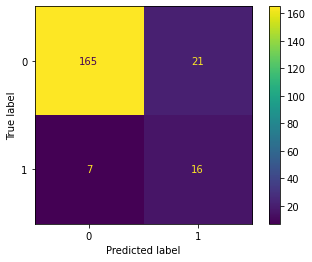

 
KNeighborsClassifier()
              precision    recall  f1-score   support

           0       0.91      0.96      0.93       186
           1       0.42      0.22      0.29        23

    accuracy                           0.88       209
   macro avg       0.66      0.59      0.61       209
weighted avg       0.85      0.88      0.86       209

0.5898784478728378


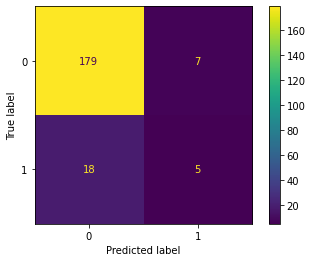

 
LGBMClassifier(is_unbalance=True)
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       186
           1       0.82      0.61      0.70        23

    accuracy                           0.94       209
   macro avg       0.89      0.80      0.83       209
weighted avg       0.94      0.94      0.94       209

0.7962833099579243


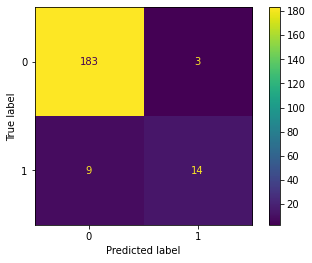

 
XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, eval_metric='auc',
              gamma=None, gpu_id=None, importance_type='gain',
              interaction_constraints=None, learning_rate=0.2,
              max_delta_step=None, max_depth=None, min_child_weight=None,
              missing=nan, monotone_constraints=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None,
              reg_alpha=None, reg_lambda=None, scale_pos_weight=1,
              subsample=None, tree_method=None, validate_parameters=None,
              verbosity=None)
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       186
           1       0.78      0.61      0.68        23

    accuracy                           0.94       209
   macro avg       0.87      0.79      0.82       209
weighted avg       0.93      0.94      0.93       209

0.793595137

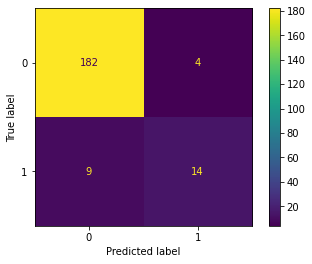

 
GradientBoostingClassifier(n_estimators=200)
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       186
           1       0.76      0.70      0.73        23

    accuracy                           0.94       209
   macro avg       0.86      0.83      0.85       209
weighted avg       0.94      0.94      0.94       209

0.834385226741468


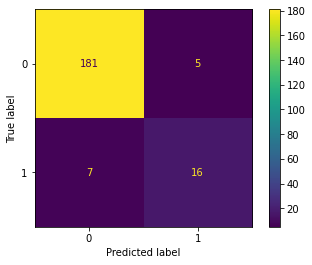

 
BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced'),
                          random_state=0, sampling_strategy=1)
              precision    recall  f1-score   support

           0       0.96      0.91      0.94       186
           1       0.50      0.70      0.58        23

    accuracy                           0.89       209
   macro avg       0.73      0.80      0.76       209
weighted avg       0.91      0.89      0.90       209

0.8048153342683497


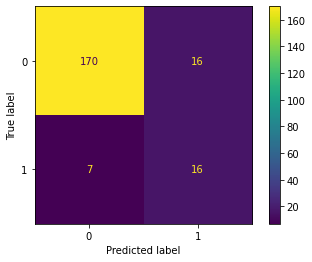

 
BalancedBaggingClassifier(base_estimator=LGBMClassifier(is_unbalance=True),
                          random_state=0, sampling_strategy=1)
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       186
           1       0.71      0.74      0.72        23

    accuracy                           0.94       209
   macro avg       0.84      0.85      0.84       209
weighted avg       0.94      0.94      0.94       209

0.8507480130902291


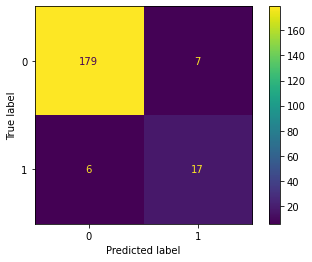

 
BalancedBaggingClassifier(base_estimator=XGBClassifier(base_score=0.5,
                                                       booster=None,
                                                       colsample_bylevel=None,
                                                       colsample_bynode=None,
                                                       colsample_bytree=None,
                                                       eval_metric='auc',
                                                       gamma=None, gpu_id=None,
                                                       importance_type='gain',
                                                       interaction_constraints=None,
                                                       learning_rate=0.2,
                                                       max_delta_step=None,
                                                       max_depth=None,
                                                       min_child_weight=None,
      

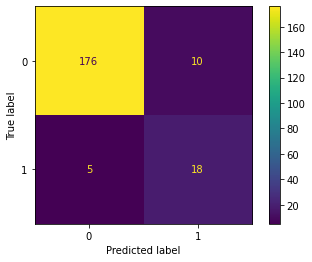

In [114]:
for model in models:
    print(model)
    test_model(X,y,model)
    print(' ')